In [1]:
import nltk
import os
import random
import platform
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from wordcloud import WordCloud
from pprint import pprint
import re
import string
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams
import pickle
import spacy
import transformers
from transformers import (BertModel, BertTokenizer, AutoTokenizer, RobertaTokenizer, RobertaModel,
                          DistilBertTokenizer, DistilBertModel,
                          ElectraTokenizer, ElectraModel,
                          MobileBertTokenizer, MobileBertModel,
                          AdamW, get_linear_schedule_with_warmup)
import sklearn
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR

import warnings
warnings.filterwarnings("ignore")

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('all-corpora')
nltk.download('punkt')
nltk.download('punkt_tab')


c:\Users\dhair\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhair\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhair\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'all-corpora'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\dhair\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\dhair\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_d

True

# Preprocessing

In [2]:
df = pd.read_csv('combined_dataset.csv', encoding='utf-8-sig')
df = df.drop_duplicates()
df = df.dropna()
print(df)

                                       review_description  rating
0       I wished I could have scored this with no star...       1
1       Only gives you one picture and it chooses it f...       1
2                          Not worth the dollar don’t buy       1
3                                  Not gonna lie it's bad       1
4       So i have just downloaded this app on another ...       5
...                                                   ...     ...
403897  That’s all, I love all the Hue products. They ...       5
403898  I literally battle this light coming on during...       1
403899  I love being able to adjust indoor and outdoor...       5
403900  I enjoy being able to control the lights from ...       5
403901  I’m the type of person to hit the snooze alarm...       4

[388606 rows x 2 columns]


In [3]:
import contractions

stop_words = list(stopwords.words('english'))

def remove_urls(text):
    urls = re.compile(r'https?://\S+|www\.\S+')
    return urls.sub(r'', text)

def remove_HTML(text):
    html = re.compile('<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile('['
                           u'\U0001F600-\U0001F64F'
                           u'\U0001F300-\U0001F5FF'
                           u'\U0001F680-\U0001F6FF'
                           u'\U0001F1E0-\U0001F1FF'
                           u'\U00002702-\U000027B0'
                           u'\U000024C2-\U0001F251'
                           ']+', flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_emoticons(text):
    emoticons = {
        u":‑\)":"Happy face or smiley",
        u":\)":"Happy face or smiley",
        u":-\]":"Happy face or smiley",
        u":\]":"Happy face or smiley",
        u":-3":"Happy face smiley",
        u":3":"Happy face smiley",
        u":->":"Happy face smiley",
        u":>":"Happy face smiley",
        u"8-\)":"Happy face smiley",
        u":o\)":"Happy face smiley",
        u":-\}":"Happy face smiley",
        u":\}":"Happy face smiley",
        u":-\)":"Happy face smiley",
        u":c\)":"Happy face smiley",
        u":\^\)":"Happy face smiley",
        u"=\]":"Happy face smiley",
        u"=\)":"Happy face smiley",
        u":‑D":"Laughing, big grin or laugh with glasses",
        u":D":"Laughing, big grin or laugh with glasses",
        u"8‑D":"Laughing, big grin or laugh with glasses",
        u"8D":"Laughing, big grin or laugh with glasses",
        u"X‑D":"Laughing, big grin or laugh with glasses",
        u"XD":"Laughing, big grin or laugh with glasses",
        u"=D":"Laughing, big grin or laugh with glasses",
        u"=3":"Laughing, big grin or laugh with glasses",
        u"B\^D":"Laughing, big grin or laugh with glasses",
        u":-\)\)":"Very happy",
        u":‑\(":"Frown, sad, andry or pouting",
        u":-\(":"Frown, sad, andry or pouting",
        u":\(":"Frown, sad, andry or pouting",
        u":‑c":"Frown, sad, andry or pouting",
        u":c":"Frown, sad, andry or pouting",
        u":‑<":"Frown, sad, andry or pouting",
        u":<":"Frown, sad, andry or pouting",
        u":‑\[":"Frown, sad, andry or pouting",
        u":\[":"Frown, sad, andry or pouting",
        u":-\|\|":"Frown, sad, andry or pouting",
        u">:\[":"Frown, sad, andry or pouting",
        u":\{":"Frown, sad, andry or pouting",
        u":@":"Frown, sad, andry or pouting",
        u">:\(":"Frown, sad, andry or pouting",
        u":'‑\(":"Crying",
        u":'\(":"Crying",
        u":'‑\)":"Tears of happiness",
        u":'\)":"Tears of happiness",
        u"D‑':":"Horror",
        u"D:<":"Disgust",
        u"D:":"Sadness",
        u"D8":"Great dismay",
        u"D;":"Great dismay",
        u"D=":"Great dismay",
        u"DX":"Great dismay",
        u":‑O":"Surprise",
        u":O":"Surprise",
        u":‑o":"Surprise",
        u":o":"Surprise",
        u":-0":"Shock",
        u"8‑0":"Yawn",
        u">:O":"Yawn",
        u":-\*":"Kiss",
        u":\*":"Kiss",
        u":X":"Kiss",
        u";‑\)":"Wink or smirk",
        u";\)":"Wink or smirk",
        u"\*-\)":"Wink or smirk",
        u"\*\)":"Wink or smirk",
        u";‑\]":"Wink or smirk",
        u";\]":"Wink or smirk",
        u";\^\)":"Wink or smirk",
        u":‑,":"Wink or smirk",
        u";D":"Wink or smirk",
        u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
        u":‑\|":"Straight face",
        u":\|":"Straight face",
        u":$":"Embarrassed or blushing",
        u":‑x":"Sealed lips or wearing braces or tongue-tied",
        u":x":"Sealed lips or wearing braces or tongue-tied",
        u":‑#":"Sealed lips or wearing braces or tongue-tied",
        u":#":"Sealed lips or wearing braces or tongue-tied",
        u":‑&":"Sealed lips or wearing braces or tongue-tied",
        u":&":"Sealed lips or wearing braces or tongue-tied",
        u"O:‑\)":"Angel, saint or innocent",
        u"O:\)":"Angel, saint or innocent",
        u"0:‑3":"Angel, saint or innocent",
        u"0:3":"Angel, saint or innocent",
        u"0:‑\)":"Angel, saint or innocent",
        u"0:\)":"Angel, saint or innocent",
        u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
        u"0;\^\)":"Angel, saint or innocent",
        u">:‑\)":"Evil or devilish",
        u">:\)":"Evil or devilish",
        u"\}:‑\)":"Evil or devilish",
        u"\}:\)":"Evil or devilish",
        u"3:‑\)":"Evil or devilish",
        u"3:\)":"Evil or devilish",
        u">;\)":"Evil or devilish",
        u"\|;‑\)":"Cool",
        u"\|‑O":"Bored",
        u":‑J":"Tongue-in-cheek",
        u"#‑\)":"Party all night",
        u"%‑\)":"Drunk or confused",
        u"%\)":"Drunk or confused",
        u":-###..":"Being sick",
        u":###..":"Being sick",
        u"<:‑\|":"Dump",
        u"\(>_<\)":"Troubled",
        u"\(>_<\)>":"Troubled",
        u"\(';'\)":"Baby",
        u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
        u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
        u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
        u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
        u"\(-_-\)zzz":"Sleeping",
        u"\(\^_-\)":"Wink",
        u"\(\(\+_\+\)\)":"Confused",
        u"\(\+o\+\)":"Confused",
        u"\(o\|o\)":"Ultraman",
        u"\^_\^":"Joyful",
        u"\(\^_\^\)/":"Joyful",
        u"\(\^O\^\)／":"Joyful",
        u"\(\^o\^\)／":"Joyful",
        u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
        u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
        u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
        u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
        u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
        u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
        u"\('_'\)":"Sad or Crying",
        u"\(/_;\)":"Sad or Crying",
        u"\(T_T\) \(;_;\)":"Sad or Crying",
        u"\(;_;":"Sad of Crying",
        u"\(;_:\)":"Sad or Crying",
        u"\(;O;\)":"Sad or Crying",
        u"\(:_;\)":"Sad or Crying",
        u"\(ToT\)":"Sad or Crying",
        u";_;":"Sad or Crying",
        u";-;":"Sad or Crying",
        u";n;":"Sad or Crying",
        u";;":"Sad or Crying",
        u"Q\.Q":"Sad or Crying",
        u"T\.T":"Sad or Crying",
        u"QQ":"Sad or Crying",
        u"Q_Q":"Sad or Crying",
        u"\(-\.-\)":"Shame",
        u"\(-_-\)":"Shame",
        u"\(一一\)":"Shame",
        u"\(；一_一\)":"Shame",
        u"\(=_=\)":"Tired",
        u"\(=\^\·\^=\)":"cat",
        u"\(=\^\·\·\^=\)":"cat",
        u"=_\^=	":"cat",
        u"\(\.\.\)":"Looking down",
        u"\(\._\.\)":"Looking down",
        u"\^m\^":"Giggling with hand covering mouth",
        u"\(\・\・?":"Confusion",
        u"\(?_?\)":"Confusion",
        u">\^_\^<":"Normal Laugh",
        u"<\^!\^>":"Normal Laugh",
        u"\^/\^":"Normal Laugh",
        u"\（\*\^_\^\*）" :"Normal Laugh",
        u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
        u"\(^\^\)":"Normal Laugh",
        u"\(\^\.\^\)":"Normal Laugh",
        u"\(\^_\^\.\)":"Normal Laugh",
        u"\(\^_\^\)":"Normal Laugh",
        u"\(\^\^\)":"Normal Laugh",
        u"\(\^J\^\)":"Normal Laugh",
        u"\(\*\^\.\^\*\)":"Normal Laugh",
        u"\(\^—\^\）":"Normal Laugh",
        u"\(#\^\.\^#\)":"Normal Laugh",
        u"\（\^—\^\）":"Waving",
        u"\(;_;\)/~~~":"Waving",
        u"\(\^\.\^\)/~~~":"Waving",
        u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
        u"\(T_T\)/~~~":"Waving",
        u"\(ToT\)/~~~":"Waving",
        u"\(\*\^0\^\*\)":"Excited",
        u"\(\*_\*\)":"Amazed",
        u"\(\*_\*;":"Amazed",
        u"\(\+_\+\) \(@_@\)":"Amazed",
        u"\(\*\^\^\)v":"Laughing,Cheerful",
        u"\(\^_\^\)v":"Laughing,Cheerful",
        u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
        u'\(-"-\)':"Worried",
        u"\(ーー;\)":"Worried",
        u"\(\^0_0\^\)":"Eyeglasses",
        u"\(\＾ｖ\＾\)":"Happy",
        u"\(\＾ｕ\＾\)":"Happy",
        u"\(\^\)o\(\^\)":"Happy",
        u"\(\^O\^\)":"Happy",
        u"\(\^o\^\)":"Happy",
        u"\)\^o\^\(":"Happy",
        u":O o_O":"Surprised",
        u"o_0":"Surprised",
        u"o\.O":"Surpised",
        u"\(o\.o\)":"Surprised",
        u"oO":"Surprised",
        u"\(\*￣m￣\)":"Dissatisfied",
        u"\(‘A`\)":"Snubbed or Deflated"
    }
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in emoticons) + u')')
    return emoticon_pattern.sub(r'', text)

def remove_mentions(text):
    mentions = re.compile('@[A-Za-z0-9_]+')
    return mentions.sub(r'', text)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatization(text):
    doc = nlp(text)
    doc = " ".join([token.lemma_ for token in doc])
    doc = doc.replace("\n", "")
    return doc

df['review_description'] = df['review_description'].str.lower() # convert to lowercase
print("Lowercasing Done!!")

df['review_description'] = df['review_description'].apply(lambda text: remove_urls(text)) # remove URLs
print("URL Removal Done!!")

df['review_description'] = df['review_description'].apply(lambda text: remove_HTML(text)) # remove HTML tags
print("HTML Removal Done!!")

df['review_description'] = df['review_description'].str.translate(str.maketrans('', '', string.punctuation)) # remove punctuations
print("Punctuation Removal Done!!")

df['review_description'] = df['review_description'].apply(lambda text: ' '.join([word for word in str(text).split() if word not in stop_words])) # remove stopwords
print("Stopwords Removal Done!!")

df['review_description'] = df['review_description'].apply(lambda text: remove_emoji(text)) # remove emojis
print("Emoji Removal Done!!")

df['review_description'] = df['review_description'].apply(lambda text: remove_emoticons(text)) # remove emoticons
print("Emoticon Removal Done!!")

df['review_description'] = df['review_description'].apply(lambda text: remove_mentions(text)) # remove mentions
print("Mention Removal Done!!")

df['review_description'] = df['review_description'].apply(lambda text: lemmatization(text)) # lemmatizing the words
print("Word Lemmatization Done!!")

df['review_description'] = df['review_description'].apply(lambda text: contractions.fix(text)) # convert i'm to i am, you're to you are, etc

df.to_csv('preprocessed_data.csv',
                index = False, encoding = 'utf-8-sig')
print("Preprocessed Dataframe Saved!!")
df = pd.read_csv('preprocessed_data.csv', encoding = 'utf-8-sig')



Lowercasing Done!!
URL Removal Done!!
HTML Removal Done!!
Punctuation Removal Done!!
Stopwords Removal Done!!
Emoji Removal Done!!
Emoticon Removal Done!!
Mention Removal Done!!
Word Lemmatization Done!!
Preprocessed Dataframe Saved!!


In [1]:
import pandas as pd

df = pd.read_csv('preprocessed_data.csv', encoding = 'utf-8-sig')
df

,review_description,rating
0,wish could score star you download let you cho...,1
1,give one picture choose,1
2,worth dollar do n’t buy,1
3,go to lie bad,1
4,download app another device mine unsure would ...,5
...,...,...
388601,that ’s love hue product work intend variety c...,5
388602,literally battle light come random time night ...,1
388603,love able adjust indoor outdoor light whether ...,5
388604,enjoy able control light phone get turn especi...,5


In [2]:
def balance_ratings(df, x):
    # Ensure we have a balanced dataset
    min_class_count = min(df['rating'].value_counts())

    # If x is less than or equal to the number of unique ratings, get equal distribution
    if x <= min_class_count * 5:
        sample_per_class = x // 5
        balanced_df = pd.concat([
            df[df['rating'] == 1].sample(n=sample_per_class, random_state=42),
            df[df['rating'] == 2].sample(n=sample_per_class, random_state=42),
            df[df['rating'] == 3].sample(n=sample_per_class, random_state=42),
            df[df['rating'] == 4].sample(n=sample_per_class, random_state=42),
            df[df['rating'] == 5].sample(n=sample_per_class, random_state=42)
        ])
        balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    else:
        raise ValueError("x is too large for the given dataset to balance ratings")

    return balanced_df



In [3]:
df = balance_ratings(df, 90000)
print(df)

                                      review_description  rating
0      forget weight watcher mobile app app user frie...       5
1      update review 5stars 1 star match next day kic...       1
2      app use sync perfectly sudden last day stop im...       3
3      app actually fast website ipad version good wo...       4
4      would give 5 star app need barcode scanner foo...       4
...                                                  ...     ...
89995  since update fourth month app connect watch ke...       1
89996  please stop add social crap every app do not n...       4
89997  get app kind skeptically advice two friend say...       5
89998  I  would give laggy app 3 star be n’t fitbit ’...       1
89999        download ios 7 app open minute click search       1

[90000 rows x 2 columns]


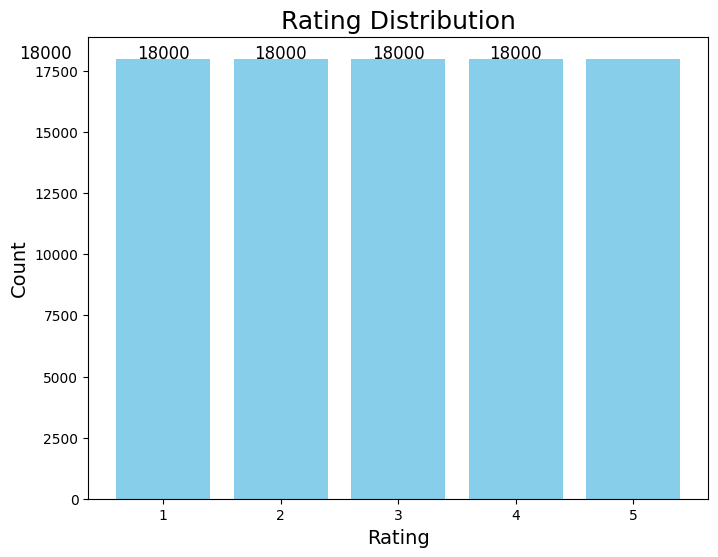

In [7]:
import matplotlib
import matplotlib.pyplot as plt

def plot_rating_distribution(df):
    rating_counts = df['rating'].value_counts().sort_index()
    plt.figure(figsize=(8, 6))
    plt.bar(rating_counts.index, rating_counts.values, color='skyblue')
    plt.title('Rating Distribution', fontsize=18)
    plt.xlabel('Rating', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    for index, value in enumerate(rating_counts.values):
        plt.text(index, value + 10, str(value), ha='center', fontsize=12)
    plt.show()

plot_rating_distribution(df)


# 5-Way Classification

100%|██████████| 89835/89835 [00:22<00:00, 3975.77it/s]


Epoch 1/20, Train Loss: 1.6098, Train Accuracy: 20.18%, Val Loss: 1.6096, Val Accuracy: 19.85%
Epoch 2/20, Train Loss: 1.6101, Train Accuracy: 19.89%, Val Loss: 1.6097, Val Accuracy: 19.82%
Epoch 3/20, Train Loss: 1.6048, Train Accuracy: 20.63%, Val Loss: 1.6154, Val Accuracy: 18.82%
Epoch 4/20, Train Loss: 1.5958, Train Accuracy: 20.97%, Val Loss: 1.6232, Val Accuracy: 20.33%
Epoch 5/20, Train Loss: 1.5872, Train Accuracy: 21.30%, Val Loss: 1.6351, Val Accuracy: 18.99%
Epoch 6/20, Train Loss: 1.5831, Train Accuracy: 21.41%, Val Loss: 1.6453, Val Accuracy: 19.88%
Epoch 7/20, Train Loss: 1.5803, Train Accuracy: 21.41%, Val Loss: 1.6536, Val Accuracy: 19.80%
Epoch 8/20, Train Loss: 1.5788, Train Accuracy: 21.52%, Val Loss: 1.6640, Val Accuracy: 20.44%
Epoch 9/20, Train Loss: 1.5783, Train Accuracy: 21.53%, Val Loss: 1.6656, Val Accuracy: 18.88%
Epoch 10/20, Train Loss: 1.5764, Train Accuracy: 21.67%, Val Loss: 1.6624, Val Accuracy: 19.75%
Epoch 11/20, Train Loss: 1.5759, Train Accuracy: 

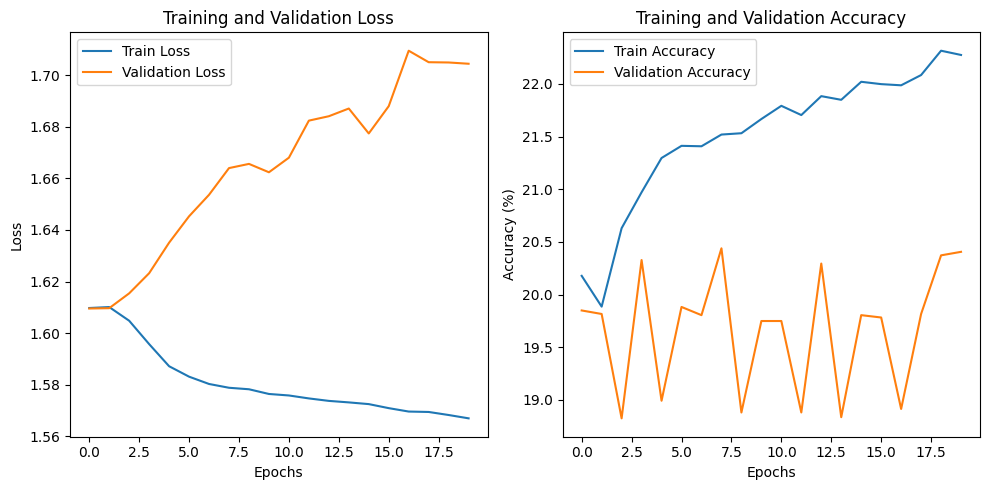

<Figure size 800x800 with 0 Axes>

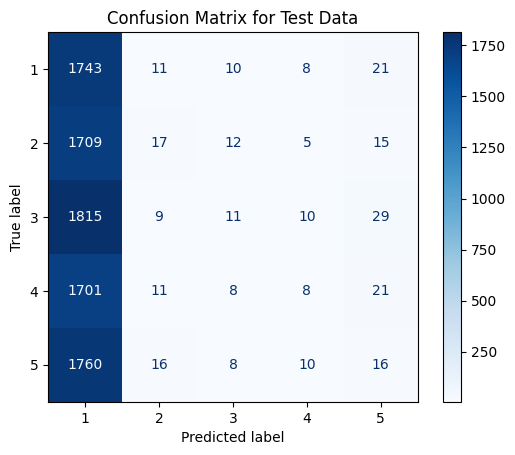

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


torch.manual_seed(50)
np.random.seed(50)


reviews = df['review_description']
ratings = df['rating']

df = df.dropna(subset=['review_description'])
reviews = df['review_description']

tqdm.pandas() 
reviews = reviews.progress_apply(lambda text: word_tokenize(text))

# Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for review in reviews for word in review))} 
vocab_size = len(vocab) + 1  

# Convert reviews to sequences
max_seq_len = 100 
reviews_seq = [[vocab.get(word, 0) for word in review[:max_seq_len]] + [0] * (max_seq_len - len(review)) for review in reviews]

# Convert to tensors
X = torch.tensor(reviews_seq, dtype=torch.long)
y = torch.tensor(ratings.values - 1, dtype=torch.long)  

# Train-test split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(list(zip(X, y)), [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model with ReLU activation
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, output_size, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.relu = nn.ReLU() 
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.relu(x[:, -1, :])  
        x = self.dropout(x)
        return self.fc(x)

# Hyperparameters
embed_size = 100
hidden_size = 128
num_layers = 2
output_size = 5 
dropout = 0.3
lr = 0.001
epochs = 20

# Initialize model
model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, output_size, dropout)

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training and validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Evaluate on test data
model.eval()
test_targets, test_preds = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# Test Accuracy
test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot losses and accuracies
plt.figure(figsize=(10, 5))

# Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_targets, test_preds, labels=list(range(output_size)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1, output_size + 1)))

# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Test Data')
plt.show()


## Add Batch Normalization

100%|██████████| 89835/89835 [00:23<00:00, 3837.11it/s] 


Epoch 1/20, Train Loss: 1.5352, Train Accuracy: 26.08%, Val Loss: 1.2742, Val Accuracy: 41.56%
Epoch 2/20, Train Loss: 1.1722, Train Accuracy: 48.31%, Val Loss: 1.1327, Val Accuracy: 50.41%
Epoch 3/20, Train Loss: 1.0873, Train Accuracy: 52.67%, Val Loss: 1.1164, Val Accuracy: 51.90%
Epoch 4/20, Train Loss: 1.0315, Train Accuracy: 55.71%, Val Loss: 1.1080, Val Accuracy: 52.13%
Epoch 5/20, Train Loss: 0.9725, Train Accuracy: 58.53%, Val Loss: 1.1371, Val Accuracy: 51.62%
Epoch 6/20, Train Loss: 0.9058, Train Accuracy: 61.90%, Val Loss: 1.1939, Val Accuracy: 51.30%
Epoch 7/20, Train Loss: 0.8352, Train Accuracy: 65.49%, Val Loss: 1.3025, Val Accuracy: 50.76%
Epoch 8/20, Train Loss: 0.7656, Train Accuracy: 68.84%, Val Loss: 1.3465, Val Accuracy: 49.96%
Epoch 9/20, Train Loss: 0.6923, Train Accuracy: 72.51%, Val Loss: 1.4078, Val Accuracy: 49.22%
Epoch 10/20, Train Loss: 0.6250, Train Accuracy: 75.43%, Val Loss: 1.6199, Val Accuracy: 48.98%
Epoch 11/20, Train Loss: 0.5682, Train Accuracy: 

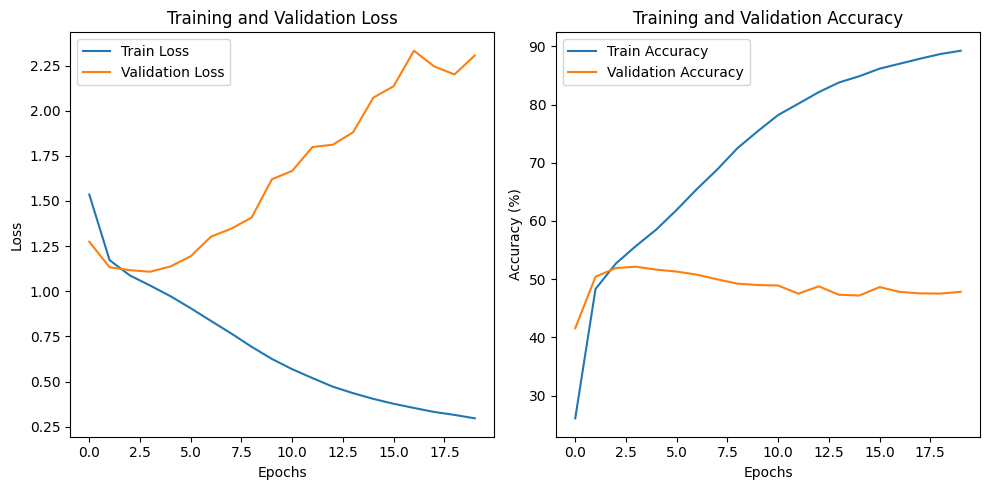

<Figure size 800x800 with 0 Axes>

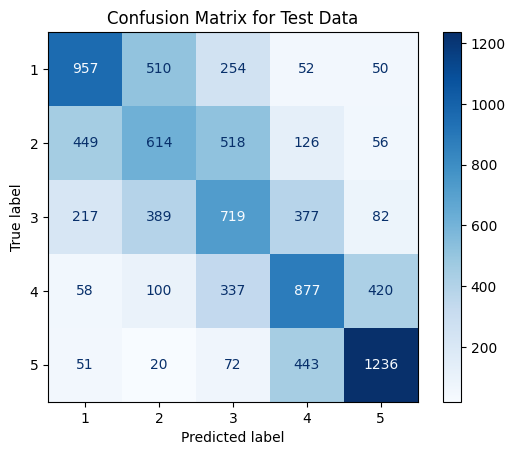

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(42)
np.random.seed(42)


reviews = df['review_description']
ratings = df['rating']

df = df.dropna(subset=['review_description'])
reviews = df['review_description']

# Tokenize reviews with a progress bar
tqdm.pandas()  
reviews = reviews.progress_apply(lambda text: word_tokenize(text))

# Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for review in reviews for word in review))} 
vocab_size = len(vocab) + 1 

# Convert reviews to sequences
max_seq_len = 100  
reviews_seq = [[vocab.get(word, 0) for word in review[:max_seq_len]] + [0] * (max_seq_len - len(review)) for review in reviews]

# Convert to tensors
X = torch.tensor(reviews_seq, dtype=torch.long)
y = torch.tensor(ratings.values - 1, dtype=torch.long)  

# Train-test split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(list(zip(X, y)), [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model with Batch Normalization
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, output_size, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  
        x = self.batch_norm(x)  
        x = self.relu(x)  
        x = self.dropout(x)
        return self.fc(x)

# Hyperparameters
embed_size = 100
hidden_size = 128
num_layers = 2
output_size = 5 
dropout = 0.3
lr = 0.001
epochs = 20

# Initialize model
model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, output_size, dropout)

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training and validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Evaluate on test data
model.eval()
test_targets, test_preds = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# Test Accuracy
test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot losses and accuracies
plt.figure(figsize=(10, 5))

# Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_targets, test_preds, labels=list(range(output_size)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1, output_size + 1)))

# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Test Data')
plt.show()


## Weight Decay (L2 Regularization)

100%|██████████| 89835/89835 [00:08<00:00, 10394.02it/s]



Training with weight decay = 1e-05

Epoch 1/20, Train Loss: 1.6180, Train Accuracy: 21.02%, Val Loss: 1.6099, Val Accuracy: 20.19%
Epoch 2/20, Train Loss: 1.6145, Train Accuracy: 19.75%, Val Loss: 1.6096, Val Accuracy: 20.24%
Epoch 3/20, Train Loss: 1.6118, Train Accuracy: 19.85%, Val Loss: 1.6095, Val Accuracy: 20.24%
Epoch 4/20, Train Loss: 1.6113, Train Accuracy: 19.89%, Val Loss: 1.6095, Val Accuracy: 20.24%
Epoch 5/20, Train Loss: 1.6123, Train Accuracy: 19.80%, Val Loss: 1.6095, Val Accuracy: 19.66%
Epoch 6/20, Train Loss: 1.6107, Train Accuracy: 20.15%, Val Loss: 1.6094, Val Accuracy: 20.39%
Epoch 7/20, Train Loss: 1.6106, Train Accuracy: 19.80%, Val Loss: 1.6095, Val Accuracy: 20.39%
Epoch 8/20, Train Loss: 1.6101, Train Accuracy: 20.17%, Val Loss: 1.6097, Val Accuracy: 19.48%
Epoch 9/20, Train Loss: 1.6102, Train Accuracy: 19.99%, Val Loss: 1.6097, Val Accuracy: 19.48%
Epoch 10/20, Train Loss: 1.6100, Train Accuracy: 19.96%, Val Loss: 1.6095, Val Accuracy: 19.48%
Epoch 11/20,

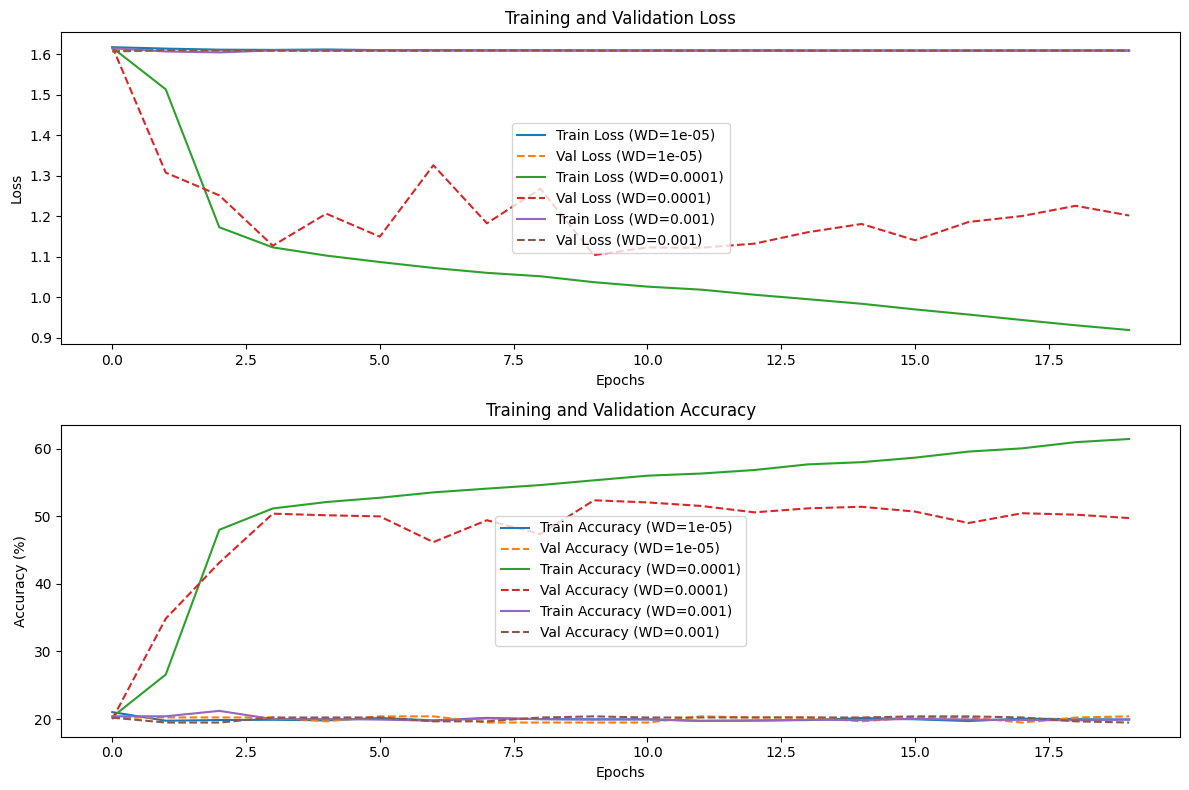


Confusion Matrix for Weight Decay 1e-05 (Test Accuracy: 0.2029):


<Figure size 800x800 with 0 Axes>

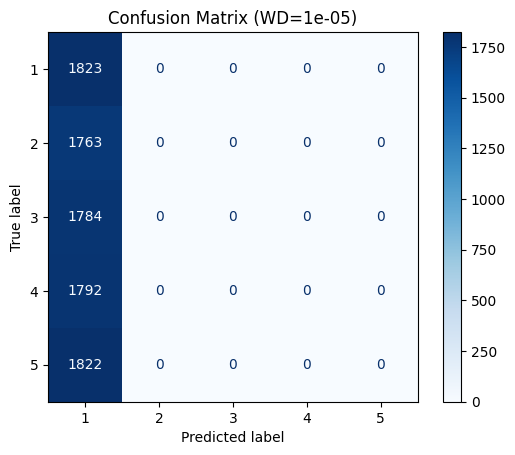


Confusion Matrix for Weight Decay 0.0001 (Test Accuracy: 0.5018):


<Figure size 800x800 with 0 Axes>

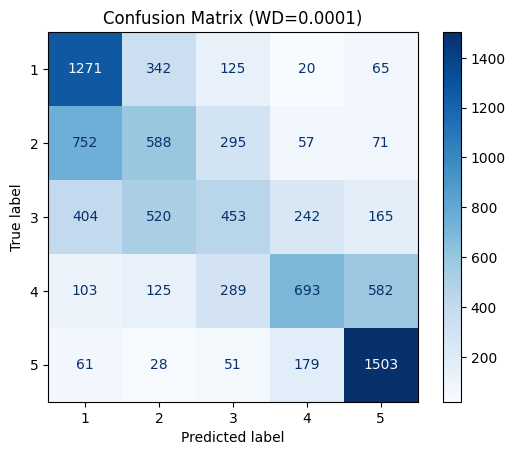


Confusion Matrix for Weight Decay 0.001 (Test Accuracy: 0.1995):


<Figure size 800x800 with 0 Axes>

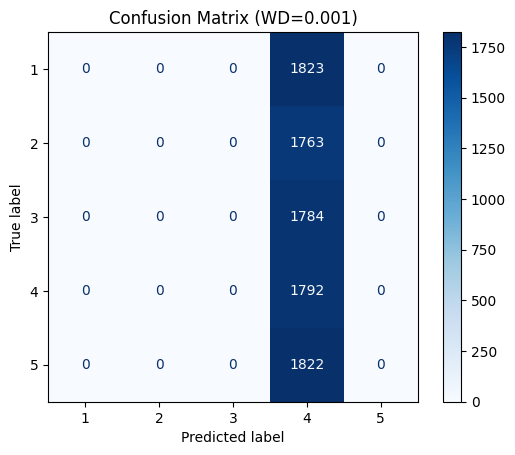

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)


reviews = df['review_description']
ratings = df['rating']

df = df.dropna(subset=['review_description'])
reviews = df['review_description']

# Tokenize reviews with a progress bar
tqdm.pandas()  
reviews = reviews.progress_apply(lambda text: word_tokenize(text))

# Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for review in reviews for word in review))} 
vocab_size = len(vocab) + 1  

# Convert reviews to sequences
max_seq_len = 100  
reviews_seq = [[vocab.get(word, 0) for word in review[:max_seq_len]] + [0] * (max_seq_len - len(review)) for review in reviews]

# Convert to tensors
X = torch.tensor(reviews_seq, dtype=torch.long)
y = torch.tensor(ratings.values - 1, dtype=torch.long)  

# Train-test split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(list(zip(X, y)), [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model with Batch Normalization
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, output_size, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  
        x = self.batch_norm(x)  
        x = self.relu(x)  
        x = self.dropout(x)
        return self.fc(x)

# Hyperparameters
embed_size = 100
hidden_size = 128
num_layers = 2
output_size = 5  
dropout = 0.3
lr = 0.001
epochs = 20
weight_decays = [1e-5, 1e-4, 1e-3]  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dictionary to save models and test results
model_results = {}
results = {wd: {'train_losses': [], 'val_losses': [], 'train_accuracies': [], 'val_accuracies': []} for wd in weight_decays}

for wd in weight_decays:
    print(f"\nTraining with weight decay = {wd}\n")
    model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, output_size, dropout)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()
                total_val += targets.size(0)

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        # Store results for current epoch
        results[wd]['train_losses'].append(train_loss)
        results[wd]['val_losses'].append(val_loss)
        results[wd]['train_accuracies'].append(train_accuracy)
        results[wd]['val_accuracies'].append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save model and evaluate on test set
    model_results[wd] = {'model': model}  
    model.eval()
    test_targets, test_preds = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    # Compute test accuracy and confusion matrix
    test_accuracy = accuracy_score(test_targets, test_preds)
    cm = confusion_matrix(test_targets, test_preds, labels=list(range(output_size)))

    model_results[wd]['test_accuracy'] = test_accuracy
    model_results[wd]['confusion_matrix'] = cm

    print(f"Test Accuracy for weight decay {wd}: {test_accuracy:.4f}")

# Plot results
plt.figure(figsize=(12, 8))

# Losses
plt.subplot(2, 1, 1)
for wd in weight_decays:
    plt.plot(results[wd]['train_losses'], label=f"Train Loss (WD={wd})")
    plt.plot(results[wd]['val_losses'], '--', label=f"Val Loss (WD={wd})")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracies
plt.subplot(2, 1, 2)
for wd in weight_decays:
    plt.plot(results[wd]['train_accuracies'], label=f"Train Accuracy (WD={wd})")
    plt.plot(results[wd]['val_accuracies'], '--', label=f"Val Accuracy (WD={wd})")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Display confusion matrices for each weight decay
for wd in weight_decays:
    cm = model_results[wd]['confusion_matrix']
    test_accuracy = model_results[wd]['test_accuracy']

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1, output_size + 1)))
    print(f"\nConfusion Matrix for Weight Decay {wd} (Test Accuracy: {test_accuracy:.4f}):")
    plt.figure(figsize=(8, 8))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix (WD={wd})')
    plt.show()


## Dropout

100%|██████████| 89835/89835 [00:08<00:00, 10039.98it/s]



Training with Dropout = 0
Epoch 1/20, Train Loss: 1.4051, Train Acc: 33.50%, Val Loss: 1.1778, Val Acc: 48.07%
Epoch 2/20, Train Loss: 1.1278, Train Acc: 50.50%, Val Loss: 1.1099, Val Acc: 51.89%
Epoch 3/20, Train Loss: 1.0707, Train Acc: 53.38%, Val Loss: 1.0935, Val Acc: 52.25%
Epoch 4/20, Train Loss: 1.0312, Train Acc: 55.46%, Val Loss: 1.0969, Val Acc: 52.14%
Epoch 5/20, Train Loss: 0.9878, Train Acc: 57.62%, Val Loss: 1.1205, Val Acc: 51.96%
Epoch 6/20, Train Loss: 0.9386, Train Acc: 60.07%, Val Loss: 1.1398, Val Acc: 51.58%
Epoch 7/20, Train Loss: 0.8760, Train Acc: 63.53%, Val Loss: 1.2159, Val Acc: 51.10%
Epoch 8/20, Train Loss: 0.8078, Train Acc: 67.01%, Val Loss: 1.2629, Val Acc: 50.75%
Epoch 9/20, Train Loss: 0.7285, Train Acc: 71.14%, Val Loss: 1.3066, Val Acc: 49.23%
Epoch 10/20, Train Loss: 0.6477, Train Acc: 74.88%, Val Loss: 1.4755, Val Acc: 49.28%
Epoch 11/20, Train Loss: 0.5696, Train Acc: 78.48%, Val Loss: 1.5842, Val Acc: 48.40%
Epoch 12/20, Train Loss: 0.5032, Tra

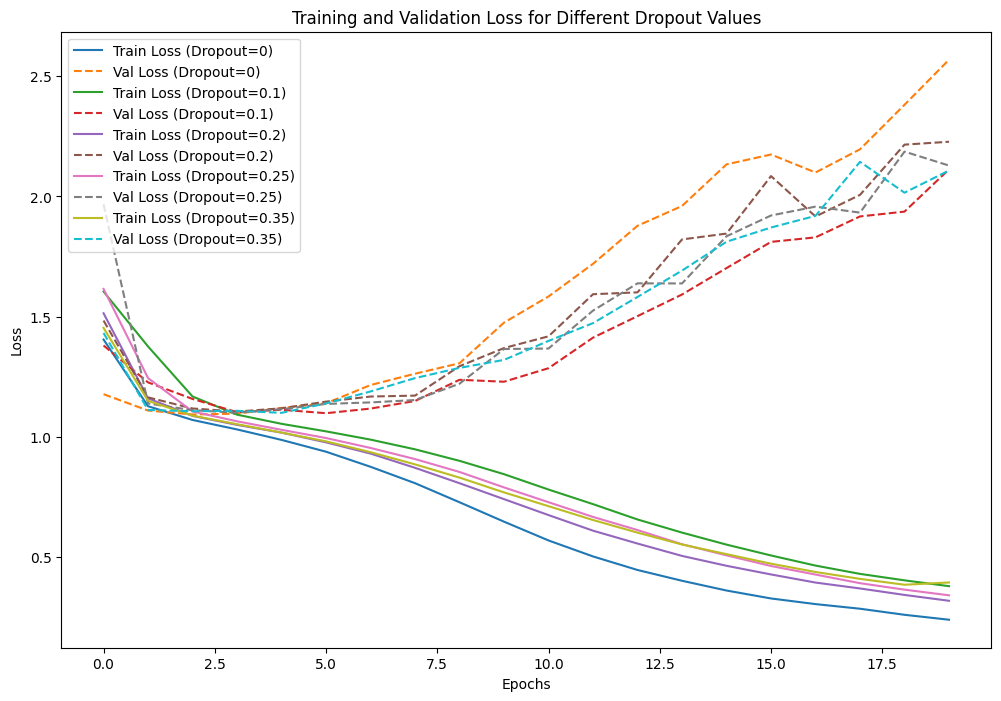

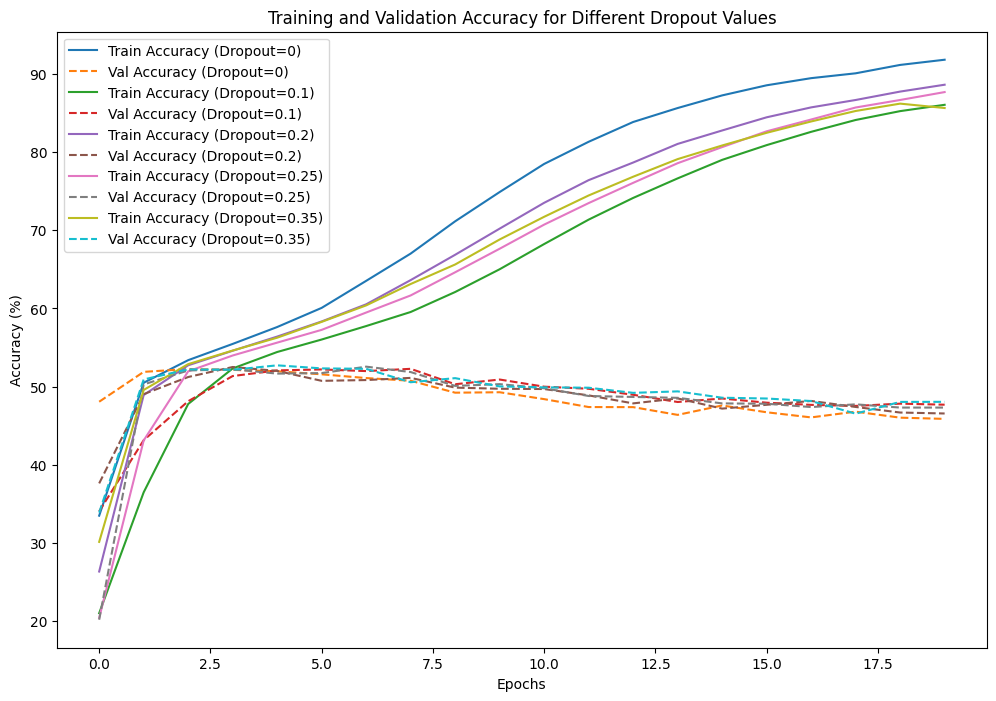

<Figure size 800x800 with 0 Axes>

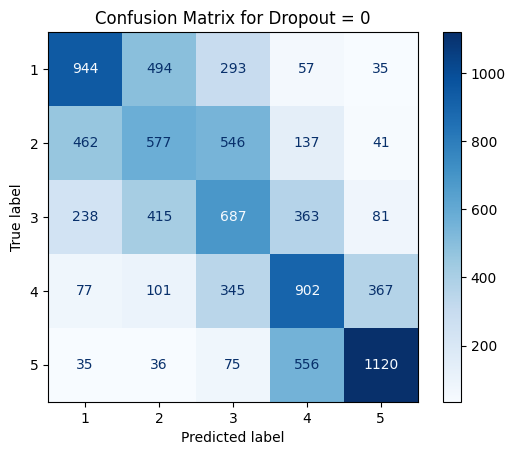

<Figure size 800x800 with 0 Axes>

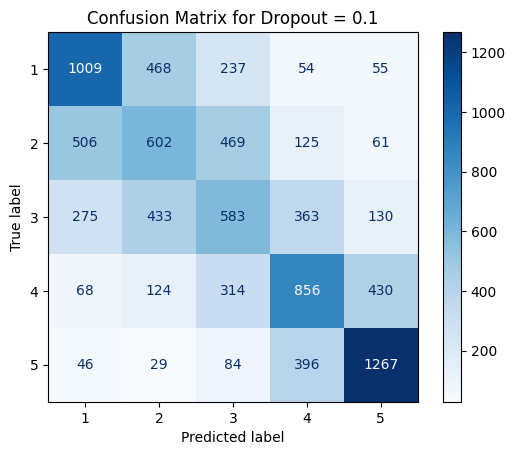

<Figure size 800x800 with 0 Axes>

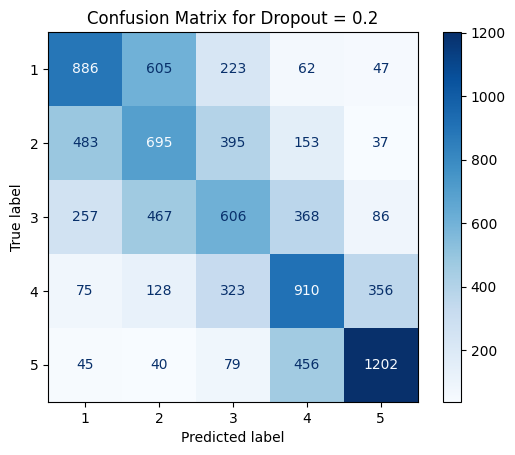

<Figure size 800x800 with 0 Axes>

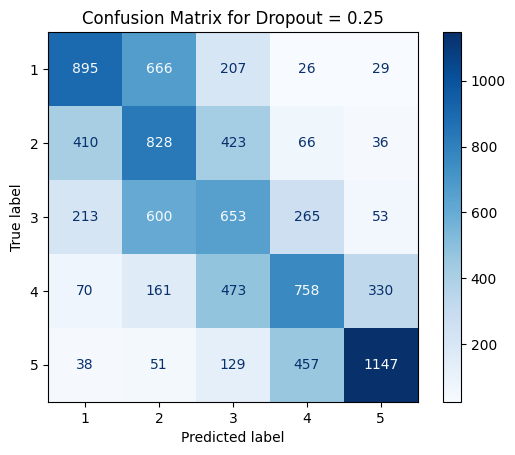

<Figure size 800x800 with 0 Axes>

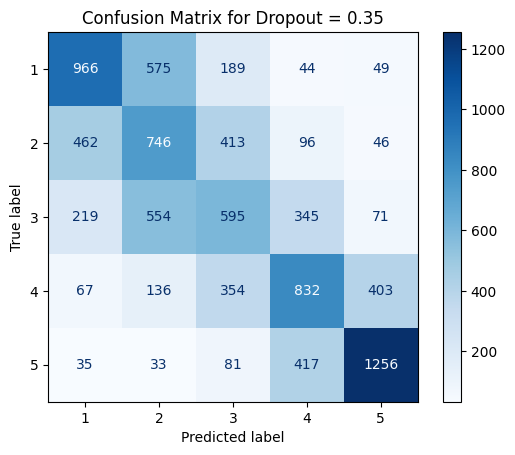

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)


df = df.dropna(subset=['review_description'])  
reviews = df['review_description']
ratings = df['rating']

# Tokenize reviews with a progress bar
tqdm.pandas()  
reviews = reviews.progress_apply(lambda text: word_tokenize(text))

# Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for review in reviews for word in review))} 
vocab_size = len(vocab) + 1  

# Convert reviews to sequences
max_seq_len = 100  
reviews_seq = [[vocab.get(word, 0) for word in review[:max_seq_len]] + [0] * (max_seq_len - len(review)) for review in reviews]

# Convert to tensors
X = torch.tensor(reviews_seq, dtype=torch.long)
y = torch.tensor(ratings.values - 1, dtype=torch.long)  

# Train-test split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(list(zip(X, y)), [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model with Batch Normalization
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, output_size, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  
        x = self.batch_norm(x)  
        x = self.relu(x)  
        x = self.dropout(x)
        return self.fc(x)

# Hyperparameters
embed_size = 100
hidden_size = 128
num_layers = 2
output_size = 5 
lr = 0.001
weight_decay = 1e-5
epochs = 20
dropout_values = [0, 0.1, 0.2, 0.25, 0.35] 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {} 
results = {} 

for dropout in dropout_values:
    print(f"\nTraining with Dropout = {dropout}")
    model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, output_size, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()
                total_val += targets.size(0)

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Save the model and evaluate on test data
    models[dropout] = model
    model.eval()
    test_targets, test_preds = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    test_accuracy = accuracy_score(test_targets, test_preds)
    results[dropout] = {'train_losses': train_losses, 'val_losses': val_losses,
                        'train_accuracies': train_accuracies, 'val_accuracies': val_accuracies,
                        'test_accuracy': test_accuracy, 'test_targets': test_targets, 'test_preds': test_preds}

    print(f"Dropout {dropout}, Test Accuracy: {test_accuracy:.4f}")

# Plot graphs for each dropout value
plt.figure(figsize=(12, 8))
for dropout in dropout_values:
    result = results[dropout]
    plt.plot(result['train_losses'], label=f'Train Loss (Dropout={dropout})')
    plt.plot(result['val_losses'], '--', label=f'Val Loss (Dropout={dropout})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Dropout Values')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for dropout in dropout_values:
    result = results[dropout]
    plt.plot(result['train_accuracies'], label=f'Train Accuracy (Dropout={dropout})')
    plt.plot(result['val_accuracies'], '--', label=f'Val Accuracy (Dropout={dropout})')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy for Different Dropout Values')
plt.legend()
plt.show()

# Confusion matrix for each dropout
for dropout in dropout_values:
    test_targets = results[dropout]['test_targets']
    test_preds = results[dropout]['test_preds']
    cm = confusion_matrix(test_targets, test_preds, labels=list(range(output_size)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1, output_size + 1)))

    plt.figure(figsize=(8, 8))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix for Dropout = {dropout}')
    plt.show()


## Hidden Size

100%|██████████| 89835/89835 [00:08<00:00, 10064.75it/s]



Training model with hidden size: 32

Epoch 1/20, Train Loss: 1.6165, Train Accuracy: 20.14%, Val Loss: 1.6107, Val Accuracy: 19.48%
Epoch 2/20, Train Loss: 1.6110, Train Accuracy: 20.04%, Val Loss: 1.6098, Val Accuracy: 19.48%
Epoch 3/20, Train Loss: 1.6103, Train Accuracy: 20.22%, Val Loss: 1.6097, Val Accuracy: 19.48%
Epoch 4/20, Train Loss: 1.6101, Train Accuracy: 19.93%, Val Loss: 1.6094, Val Accuracy: 20.24%
Epoch 5/20, Train Loss: 1.6099, Train Accuracy: 19.81%, Val Loss: 1.6095, Val Accuracy: 20.23%
Epoch 6/20, Train Loss: 1.6097, Train Accuracy: 19.86%, Val Loss: 1.6096, Val Accuracy: 19.66%
Epoch 7/20, Train Loss: 1.6098, Train Accuracy: 19.57%, Val Loss: 1.6096, Val Accuracy: 19.66%
Epoch 8/20, Train Loss: 1.6096, Train Accuracy: 19.98%, Val Loss: 1.6098, Val Accuracy: 19.66%
Epoch 9/20, Train Loss: 1.6096, Train Accuracy: 19.73%, Val Loss: 1.6096, Val Accuracy: 20.23%
Epoch 10/20, Train Loss: 1.6096, Train Accuracy: 19.76%, Val Loss: 1.6095, Val Accuracy: 19.66%
Epoch 11/20

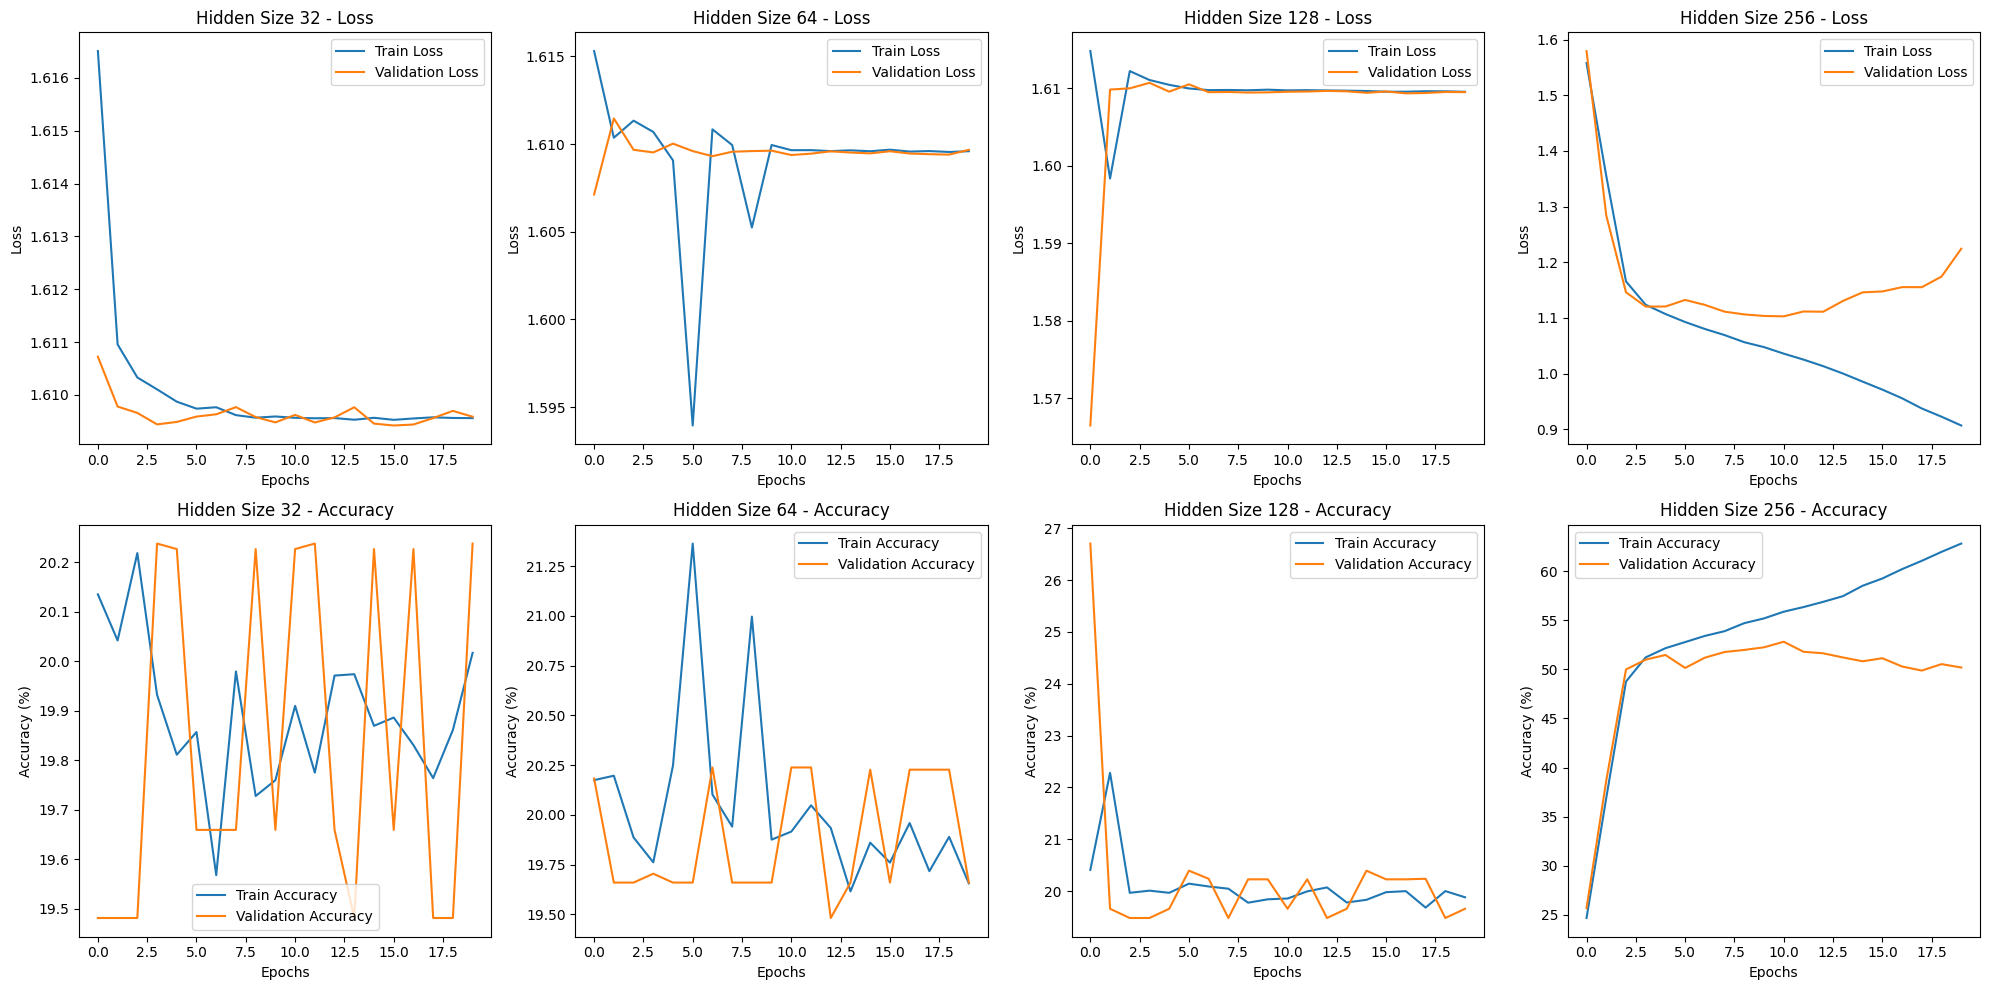


Confusion Matrix for Hidden Size 32:


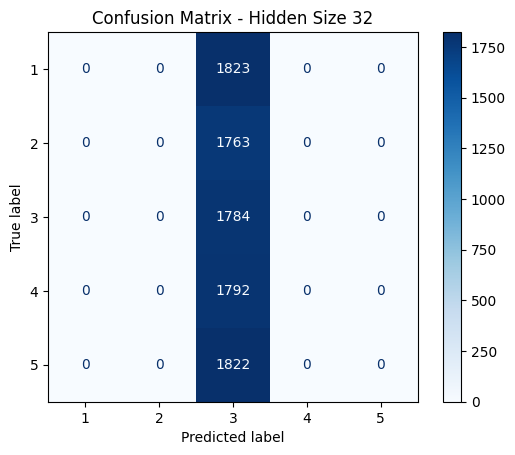


Confusion Matrix for Hidden Size 64:


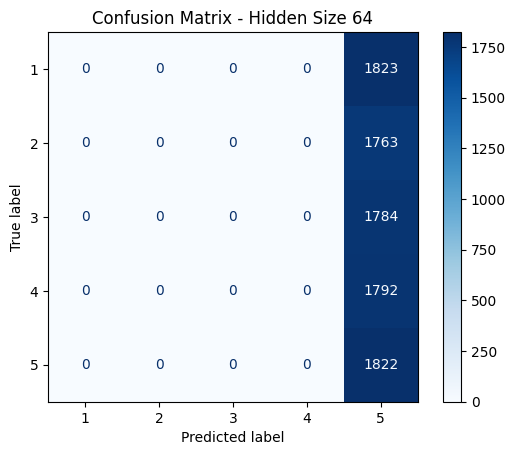


Confusion Matrix for Hidden Size 128:


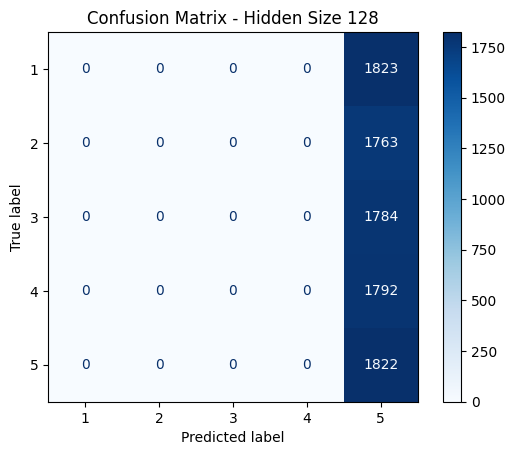


Confusion Matrix for Hidden Size 256:


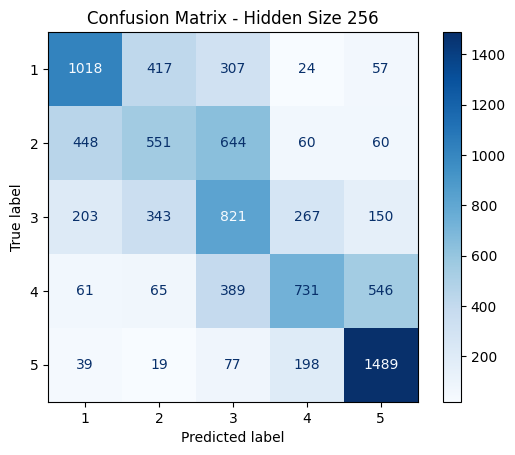

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(42)
np.random.seed(42)


reviews = df['review_description']
ratings = df['rating']

df = df.dropna(subset=['review_description'])
reviews = df['review_description']

# Tokenize reviews with a progress bar
tqdm.pandas()  
reviews = reviews.progress_apply(lambda text: word_tokenize(text))

# Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for review in reviews for word in review))} 
vocab_size = len(vocab) + 1 

max_seq_len = 100 
reviews_seq = [[vocab.get(word, 0) for word in review[:max_seq_len]] + [0] * (max_seq_len - len(review)) for review in reviews]

# Convert to tensors
X = torch.tensor(reviews_seq, dtype=torch.long)
y = torch.tensor(ratings.values - 1, dtype=torch.long) 

# Train-test split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(list(zip(X, y)), [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model with Batch Normalization
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, output_size, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  
        x = self.batch_norm(x) 
        x = self.relu(x)  
        x = self.dropout(x)
        return self.fc(x)

# Hyperparameters
embed_size = 100
num_layers = 2
output_size = 5 
dropout = 0.3
lr = 0.001
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set different hidden layer sizes
hidden_layer_sizes = [32, 64, 128, 256]
results = {}

for hidden_size in hidden_layer_sizes:
    print(f"\nTraining model with hidden size: {hidden_size}\n")

    # Initialize model
    model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, output_size, dropout).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

    # Training and validation
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()
                total_val += targets.size(0)

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save model
    model_path = f"rnn_model_hidden_{hidden_size}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model with hidden size {hidden_size} saved at {model_path}.")

    # Evaluate on test data
    model.eval()
    test_targets, test_preds = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    # Test Accuracy
    test_accuracy = accuracy_score(test_targets, test_preds)
    print(f"Test Accuracy for hidden size {hidden_size}: {test_accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(test_targets, test_preds, labels=list(range(output_size)))
    results[hidden_size] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'confusion_matrix': cm,
    }

# Plot results for different hidden sizes
plt.figure(figsize=(20, 10))

for idx, hidden_size in enumerate(hidden_layer_sizes):
    # Loss plot
    plt.subplot(2, len(hidden_layer_sizes), idx + 1)
    plt.plot(results[hidden_size]['train_losses'], label='Train Loss')
    plt.plot(results[hidden_size]['val_losses'], label='Validation Loss')
    plt.title(f"Hidden Size {hidden_size} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(2, len(hidden_layer_sizes), idx + len(hidden_layer_sizes) + 1)
    plt.plot(results[hidden_size]['train_accuracies'], label='Train Accuracy')
    plt.plot(results[hidden_size]['val_accuracies'], label='Validation Accuracy')
    plt.title(f"Hidden Size {hidden_size} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

plt.tight_layout()
plt.show()

# Display confusion matrices
for hidden_size in hidden_layer_sizes:
    print(f"\nConfusion Matrix for Hidden Size {hidden_size}:")
    cm = results[hidden_size]['confusion_matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1, output_size + 1)))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - Hidden Size {hidden_size}")
    plt.show()


## StepLR

100%|██████████| 89835/89835 [00:09<00:00, 9597.05it/s] 


Epoch 1/20, Train Loss: 1.6131, Train Accuracy: 20.53%, Val Loss: 1.9113, Val Accuracy: 20.25%
Epoch 2/20, Train Loss: 1.2730, Train Accuracy: 41.04%, Val Loss: 1.3154, Val Accuracy: 37.99%
Epoch 3/20, Train Loss: 1.1517, Train Accuracy: 49.37%, Val Loss: 1.1366, Val Accuracy: 50.26%
Epoch 4/20, Train Loss: 1.1142, Train Accuracy: 51.59%, Val Loss: 1.1156, Val Accuracy: 51.15%
Epoch 5/20, Train Loss: 1.0948, Train Accuracy: 52.67%, Val Loss: 1.1769, Val Accuracy: 49.18%
Epoch 6/20, Train Loss: 1.0589, Train Accuracy: 54.48%, Val Loss: 1.1060, Val Accuracy: 52.18%
Epoch 7/20, Train Loss: 1.0411, Train Accuracy: 55.10%, Val Loss: 1.1112, Val Accuracy: 52.00%
Epoch 8/20, Train Loss: 1.0271, Train Accuracy: 56.01%, Val Loss: 1.1160, Val Accuracy: 51.72%
Epoch 9/20, Train Loss: 1.0143, Train Accuracy: 56.54%, Val Loss: 1.1171, Val Accuracy: 52.03%
Epoch 10/20, Train Loss: 1.0020, Train Accuracy: 57.13%, Val Loss: 1.1260, Val Accuracy: 52.45%
Epoch 11/20, Train Loss: 0.9584, Train Accuracy: 

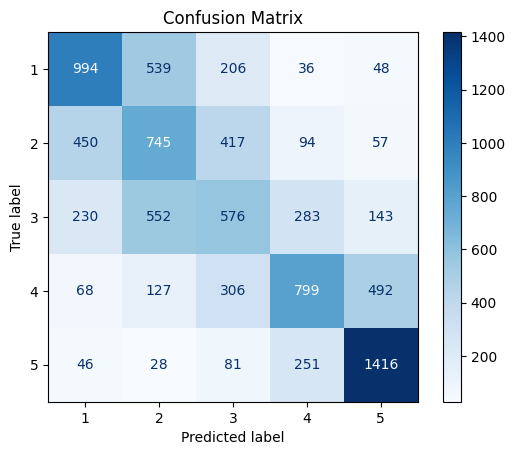

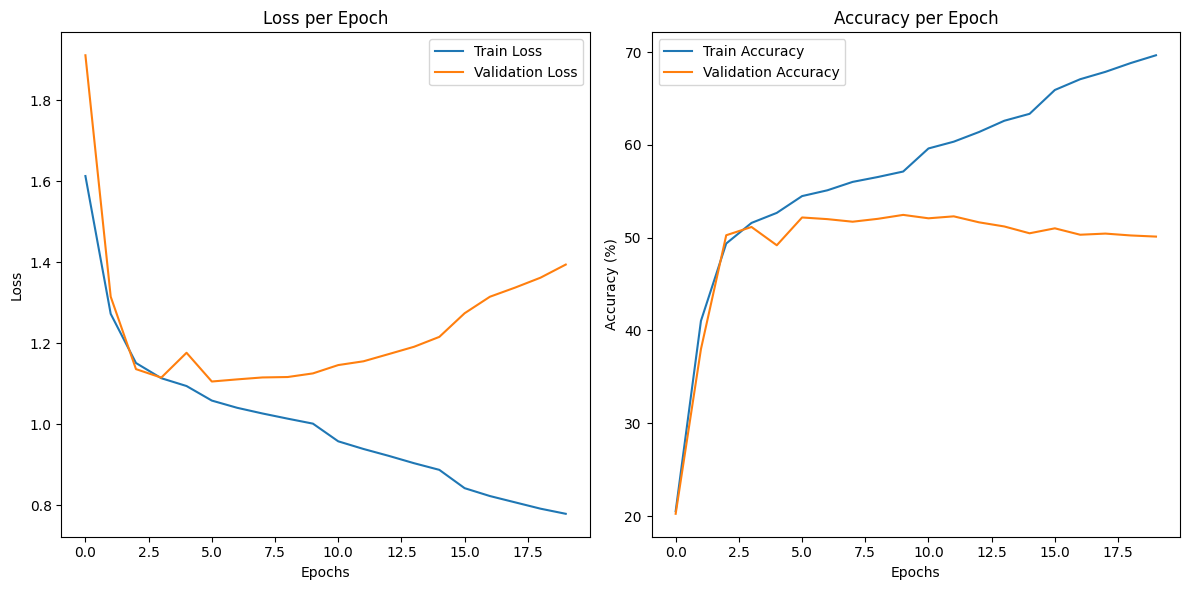

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(42)
np.random.seed(42)

# Data preprocessing
reviews = df['review_description']
ratings = df['rating']

df = df.dropna(subset=['review_description'])
reviews = df['review_description']

# Tokenize reviews with a progress bar
tqdm.pandas() 
reviews = reviews.progress_apply(lambda text: word_tokenize(text))

# Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for review in reviews for word in review))} 
vocab_size = len(vocab) + 1 

# Convert reviews to sequences
max_seq_len = 100 
reviews_seq = [[vocab.get(word, 0) for word in review[:max_seq_len]] + [0] * (max_seq_len - len(review)) for review in reviews]

# Convert to tensors
X = torch.tensor(reviews_seq, dtype=torch.long)
y = torch.tensor(ratings.values - 1, dtype=torch.long) 

# Train-test split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(list(zip(X, y)), [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model with Batch Normalization
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, output_size, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :] 
        x = self.batch_norm(x)  
        x = self.relu(x)  
        x = self.dropout(x)
        return self.fc(x)

# Hyperparameters
embed_size = 100
hidden_size = 64
num_layers = 2
output_size = 5 
dropout = 0.2
lr = 0.001
step_size = 5 
gamma = 0.5  
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, output_size, dropout).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training and validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    scheduler.step()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Save model
model_path = "rnn_model_hidden_64.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}.")

# Evaluate on test data
model.eval()
test_targets, test_preds = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# Test Accuracy
test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_targets, test_preds, labels=list(range(output_size)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1, output_size + 1)))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Plot losses and accuracies
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


# Regression

## Base Model with Batch Normalization

100%|██████████| 89835/89835 [00:09<00:00, 9953.23it/s] 


Epoch 1/20, Train Loss: 2.2862, Train Accuracy: 20.12%, Val Loss: 3.5239, Val Accuracy: 20.17%
Epoch 2/20, Train Loss: 1.3770, Train Accuracy: 30.38%, Val Loss: 1.0333, Val Accuracy: 37.58%
Epoch 3/20, Train Loss: 0.9132, Train Accuracy: 38.06%, Val Loss: 0.8938, Val Accuracy: 43.37%
Epoch 4/20, Train Loss: 0.8123, Train Accuracy: 41.54%, Val Loss: 0.8915, Val Accuracy: 47.45%
Epoch 5/20, Train Loss: 0.7437, Train Accuracy: 44.25%, Val Loss: 0.8338, Val Accuracy: 48.93%
Epoch 6/20, Train Loss: 0.6838, Train Accuracy: 46.13%, Val Loss: 0.7864, Val Accuracy: 47.07%
Epoch 7/20, Train Loss: 0.6186, Train Accuracy: 49.19%, Val Loss: 0.8100, Val Accuracy: 49.58%
Epoch 8/20, Train Loss: 0.5558, Train Accuracy: 51.66%, Val Loss: 0.8562, Val Accuracy: 49.87%
Epoch 9/20, Train Loss: 0.4977, Train Accuracy: 54.75%, Val Loss: 0.9190, Val Accuracy: 48.11%
Epoch 10/20, Train Loss: 0.4483, Train Accuracy: 57.45%, Val Loss: 0.8634, Val Accuracy: 48.79%
Epoch 11/20, Train Loss: 0.3999, Train Accuracy: 

<Figure size 800x800 with 0 Axes>

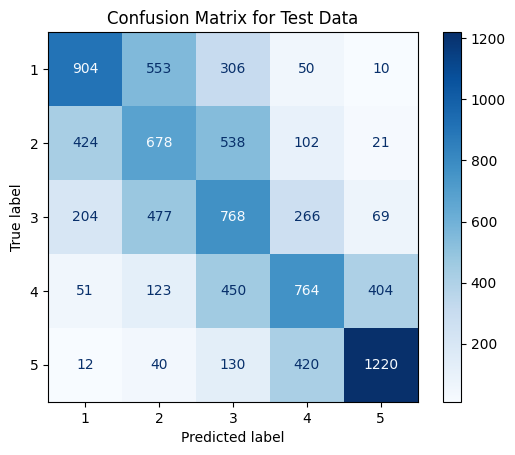

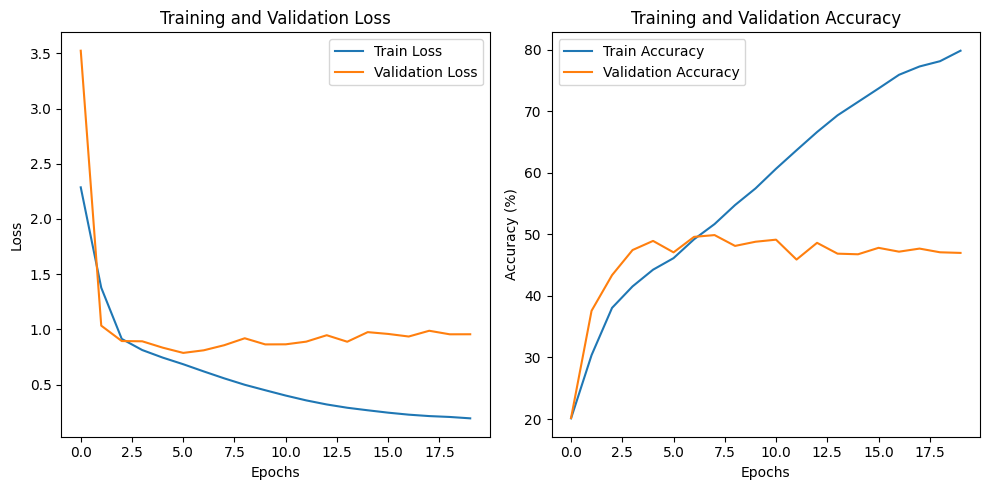

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm


torch.manual_seed(42)
np.random.seed(42)

reviews = df['review_description']
ratings = df['rating']

df = df.dropna(subset=['review_description'])
reviews = df['review_description']

# Tokenize reviews with a progress bar
tqdm.pandas()  
reviews = reviews.progress_apply(lambda text: word_tokenize(text))

# Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for review in reviews for word in review))} 
vocab_size = len(vocab) + 1 

# Convert reviews to sequences
max_seq_len = 100  
reviews_seq = [[vocab.get(word, 0) for word in review[:max_seq_len]] + [0] * (max_seq_len - len(review)) for review in reviews]

# Convert to tensors
X = torch.tensor(reviews_seq, dtype=torch.long)
y = torch.tensor(ratings.values, dtype=torch.float32)  

# Train-test split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(list(zip(X, y)), [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define LSTM Model with Batch Normalization for Regression
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, 1) 
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  
        x = self.batch_norm(x)  
        x = self.relu(x)  
        x = self.dropout(x)
        return self.fc(x)

# Hyperparameters
embed_size = 100
hidden_size = 128
num_layers = 2
dropout = 0.3
lr = 0.001
epochs = 20

# Initialize model
model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, dropout)

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training and validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Round outputs to nearest integer and clamp between 1 and 5
        rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
        correct_train += (rounded_preds == targets).sum().item()
        total_train += targets.size(0)

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Round outputs to nearest integer and clamp between 1 and 5
            rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
            correct_val += (rounded_preds == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Evaluate on test data
model.eval()
test_targets, test_preds = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).squeeze()
        rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
        test_preds.extend(rounded_preds.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# Test Accuracy
correct_test = sum(1 for t, p in zip(test_targets, test_preds) if t == p)
total_test = len(test_targets)
test_accuracy = 100 * correct_test / total_test 

# Test MAE (Mean Absolute Error)
mae = mean_absolute_error(test_targets, test_preds)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test MAE: {mae:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_targets, test_preds, labels=[1, 2, 3, 4, 5])

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])

# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Test Data')
plt.show()

# Plot losses and accuracies
plt.figure(figsize=(10, 5))

# Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Weight Decay

Weight Decay: 1e-05, Epoch 1/20, Train Loss: 2.2927, Train Accuracy: 20.04%, Val Loss: 4.3426, Val Accuracy: 20.58%
Weight Decay: 1e-05, Epoch 2/20, Train Loss: 1.4050, Train Accuracy: 30.27%, Val Loss: 1.3465, Val Accuracy: 36.38%
Weight Decay: 1e-05, Epoch 3/20, Train Loss: 0.8524, Train Accuracy: 40.54%, Val Loss: 1.0223, Val Accuracy: 42.07%
Weight Decay: 1e-05, Epoch 4/20, Train Loss: 0.7584, Train Accuracy: 43.85%, Val Loss: 0.7941, Val Accuracy: 48.99%
Weight Decay: 1e-05, Epoch 5/20, Train Loss: 0.7021, Train Accuracy: 45.78%, Val Loss: 0.7881, Val Accuracy: 49.14%
Weight Decay: 1e-05, Epoch 6/20, Train Loss: 0.6574, Train Accuracy: 47.36%, Val Loss: 0.8096, Val Accuracy: 49.06%
Weight Decay: 1e-05, Epoch 7/20, Train Loss: 0.6095, Train Accuracy: 49.11%, Val Loss: 0.8003, Val Accuracy: 50.05%
Weight Decay: 1e-05, Epoch 8/20, Train Loss: 0.5646, Train Accuracy: 51.00%, Val Loss: 0.8049, Val Accuracy: 49.78%
Weight Decay: 1e-05, Epoch 9/20, Train Loss: 0.5249, Train Accuracy: 53.

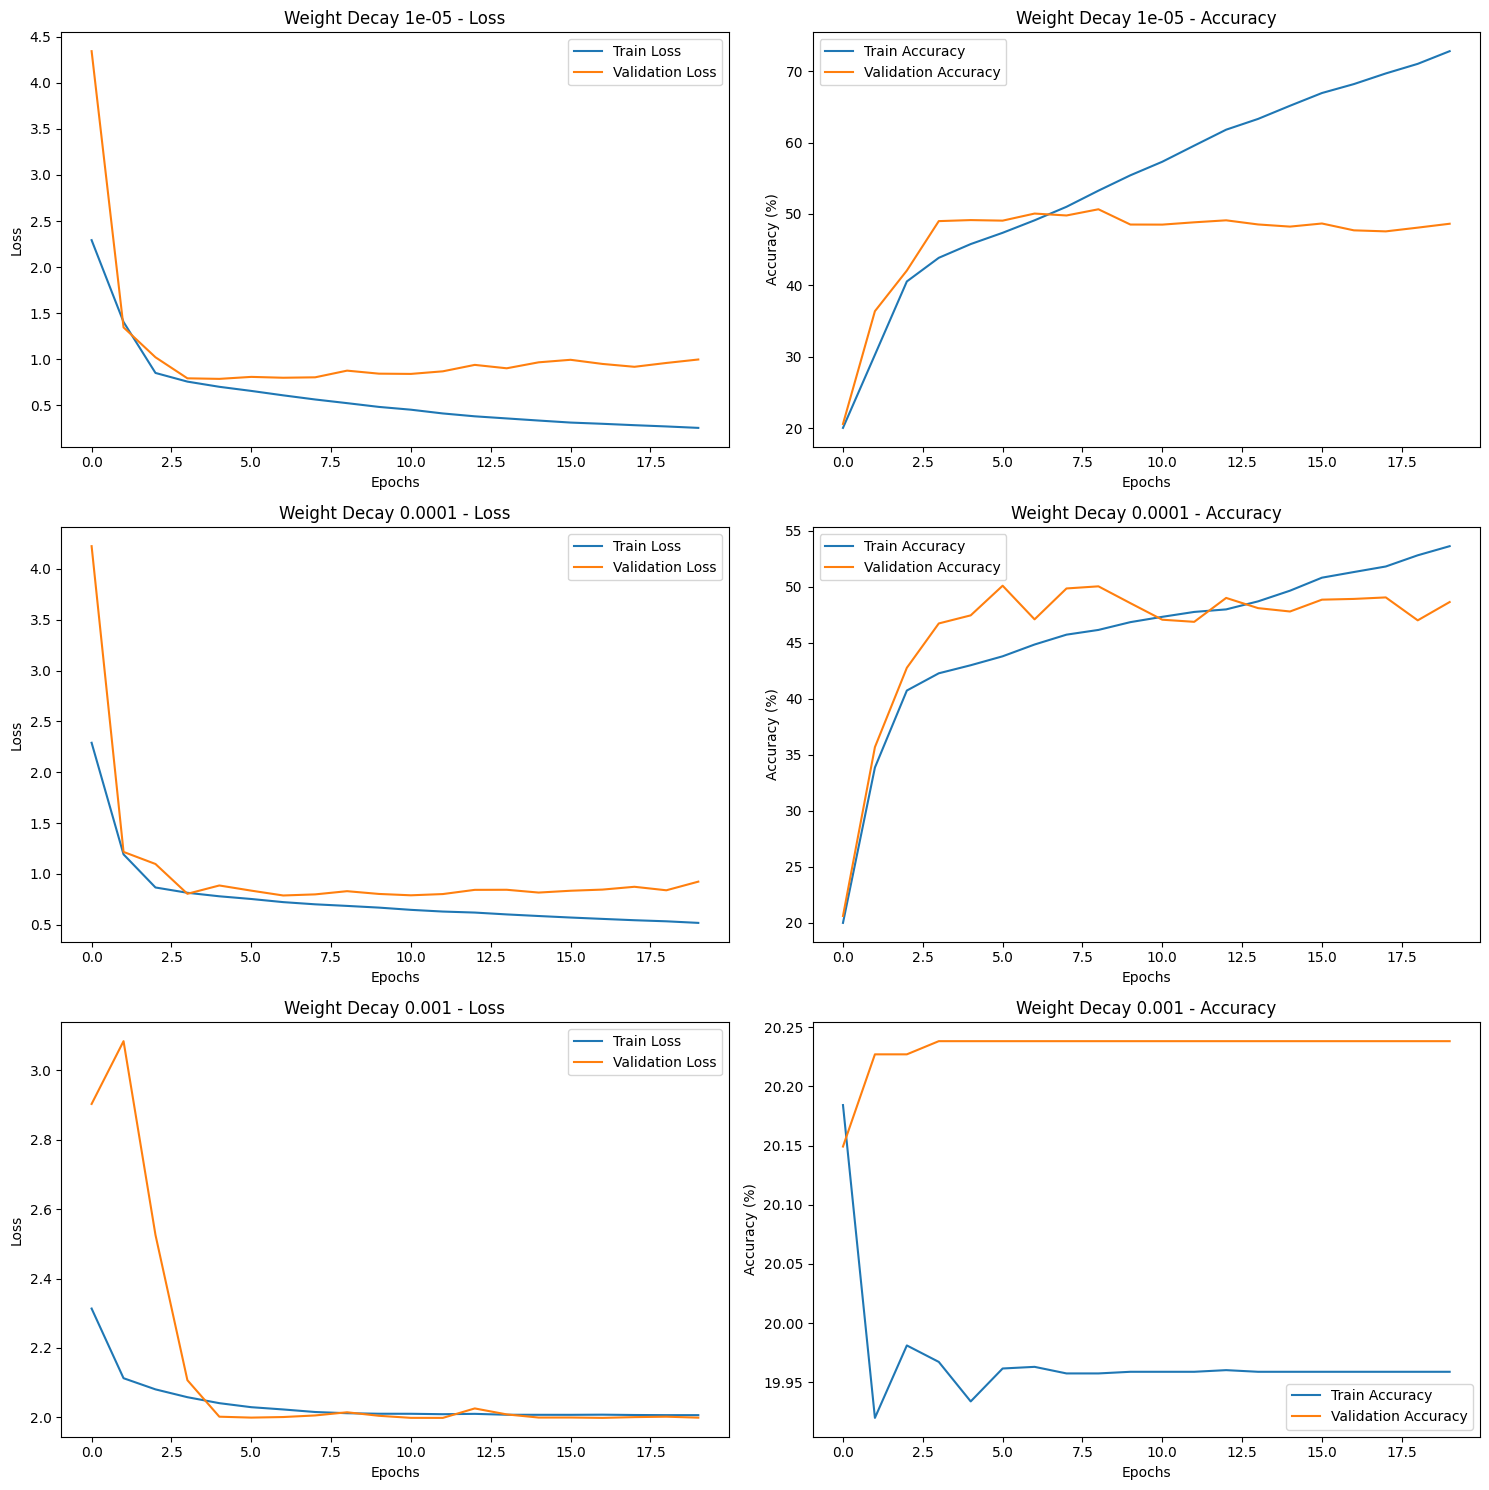

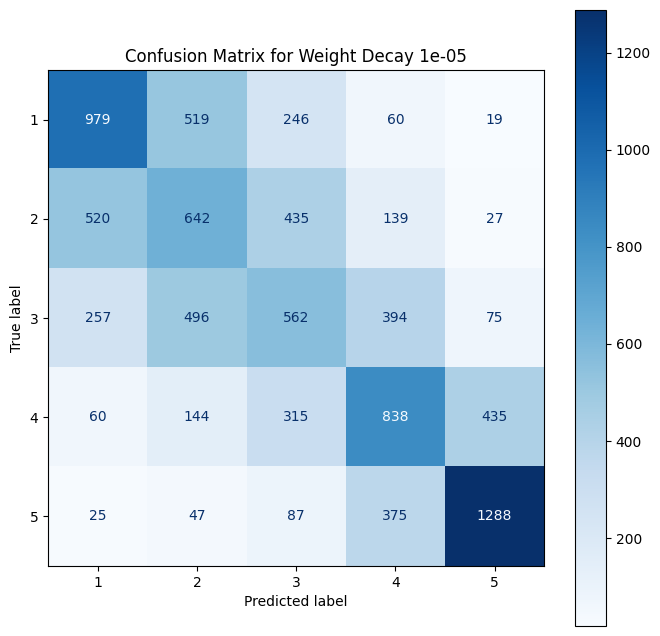

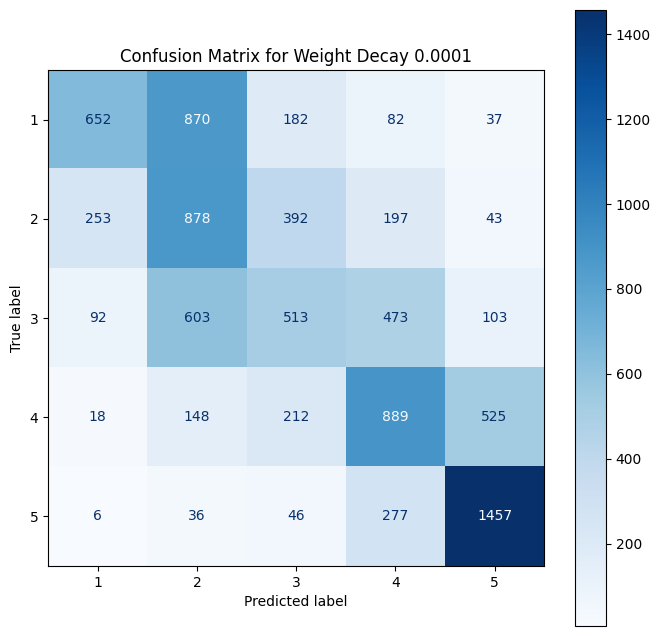

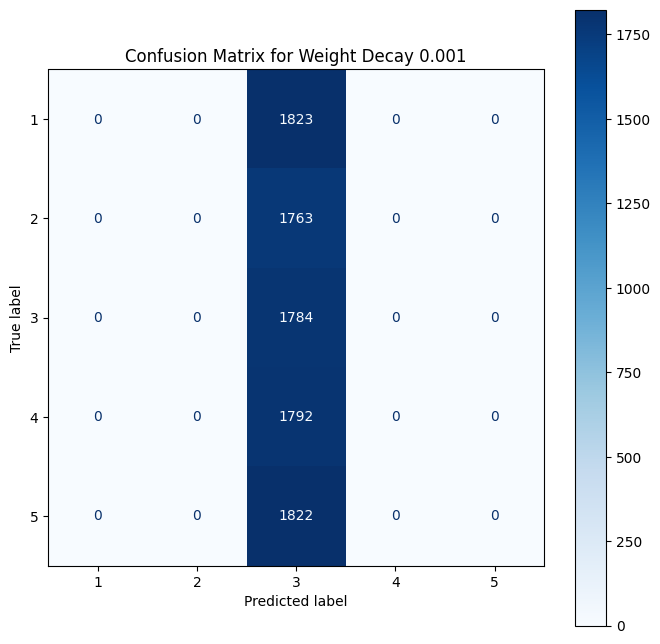

In [15]:
# Hyperparameters
embed_size = 100
hidden_size = 128
num_layers = 2
dropout = 0.3  
weight_decays = [1e-5, 1e-4, 1e-3]
lr = 0.001
epochs = 20

fig, axes = plt.subplots(len(weight_decays), 2, figsize=(15, 5 * len(weight_decays)))
confusion_matrices = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and evaluate for different weight decay values
for i, weight_decay in enumerate(weight_decays):
    model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
            correct_train += (rounded_preds == targets).sum().item()
            total_train += targets.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
                correct_val += (rounded_preds == targets).sum().item()
                total_val += targets.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Weight Decay: {weight_decay}, Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    # Test Evaluation
    model.eval()
    test_targets, test_preds = [], []
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
            correct_test += (rounded_preds == targets).sum().item()
            total_test += targets.size(0)
            test_preds.extend(rounded_preds.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test
    print(f"Weight Decay: {weight_decay}, Test Accuracy: {test_accuracy:.2f}%")
    
    cm = confusion_matrix(test_targets, test_preds, labels=[1, 2, 3, 4, 5])
    confusion_matrices[weight_decay] = cm

    # Plot losses and accuracies
    ax1, ax2 = axes[i]
    ax1.plot(train_losses, label="Train Loss")
    ax1.plot(val_losses, label="Validation Loss")
    ax1.set_title(f"Weight Decay {weight_decay} - Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(train_accuracies, label="Train Accuracy")
    ax2.plot(val_accuracies, label="Validation Accuracy")
    ax2.set_title(f"Weight Decay {weight_decay} - Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrices
for weight_decay, cm in confusion_matrices.items():
    fig_cm, ax_cm = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
    disp.plot(cmap="Blues", values_format="d", ax=ax_cm)
    ax_cm.set_title(f"Confusion Matrix for Weight Decay {weight_decay}")
    plt.show()


## Dropout

Dropout: 0.1, Epoch 1/20, Train Loss: 2.1784, Train Accuracy: 20.17%, Val Loss: 4.7151, Val Accuracy: 20.77%
Dropout: 0.1, Epoch 2/20, Train Loss: 1.7429, Train Accuracy: 25.11%, Val Loss: 1.0155, Val Accuracy: 37.92%
Dropout: 0.1, Epoch 3/20, Train Loss: 0.8979, Train Accuracy: 38.94%, Val Loss: 0.8109, Val Accuracy: 40.47%
Dropout: 0.1, Epoch 4/20, Train Loss: 0.7984, Train Accuracy: 42.53%, Val Loss: 0.7975, Val Accuracy: 39.05%
Dropout: 0.1, Epoch 5/20, Train Loss: 0.7608, Train Accuracy: 43.63%, Val Loss: 0.7622, Val Accuracy: 47.70%
Dropout: 0.1, Epoch 6/20, Train Loss: 0.7227, Train Accuracy: 45.34%, Val Loss: 0.7615, Val Accuracy: 44.96%
Dropout: 0.1, Epoch 7/20, Train Loss: 0.6996, Train Accuracy: 46.05%, Val Loss: 0.8008, Val Accuracy: 45.76%
Dropout: 0.1, Epoch 8/20, Train Loss: 0.6729, Train Accuracy: 47.45%, Val Loss: 0.7656, Val Accuracy: 46.37%
Dropout: 0.1, Epoch 9/20, Train Loss: 0.6472, Train Accuracy: 48.78%, Val Loss: 0.7632, Val Accuracy: 45.89%
Dropout: 0.1, Epoch

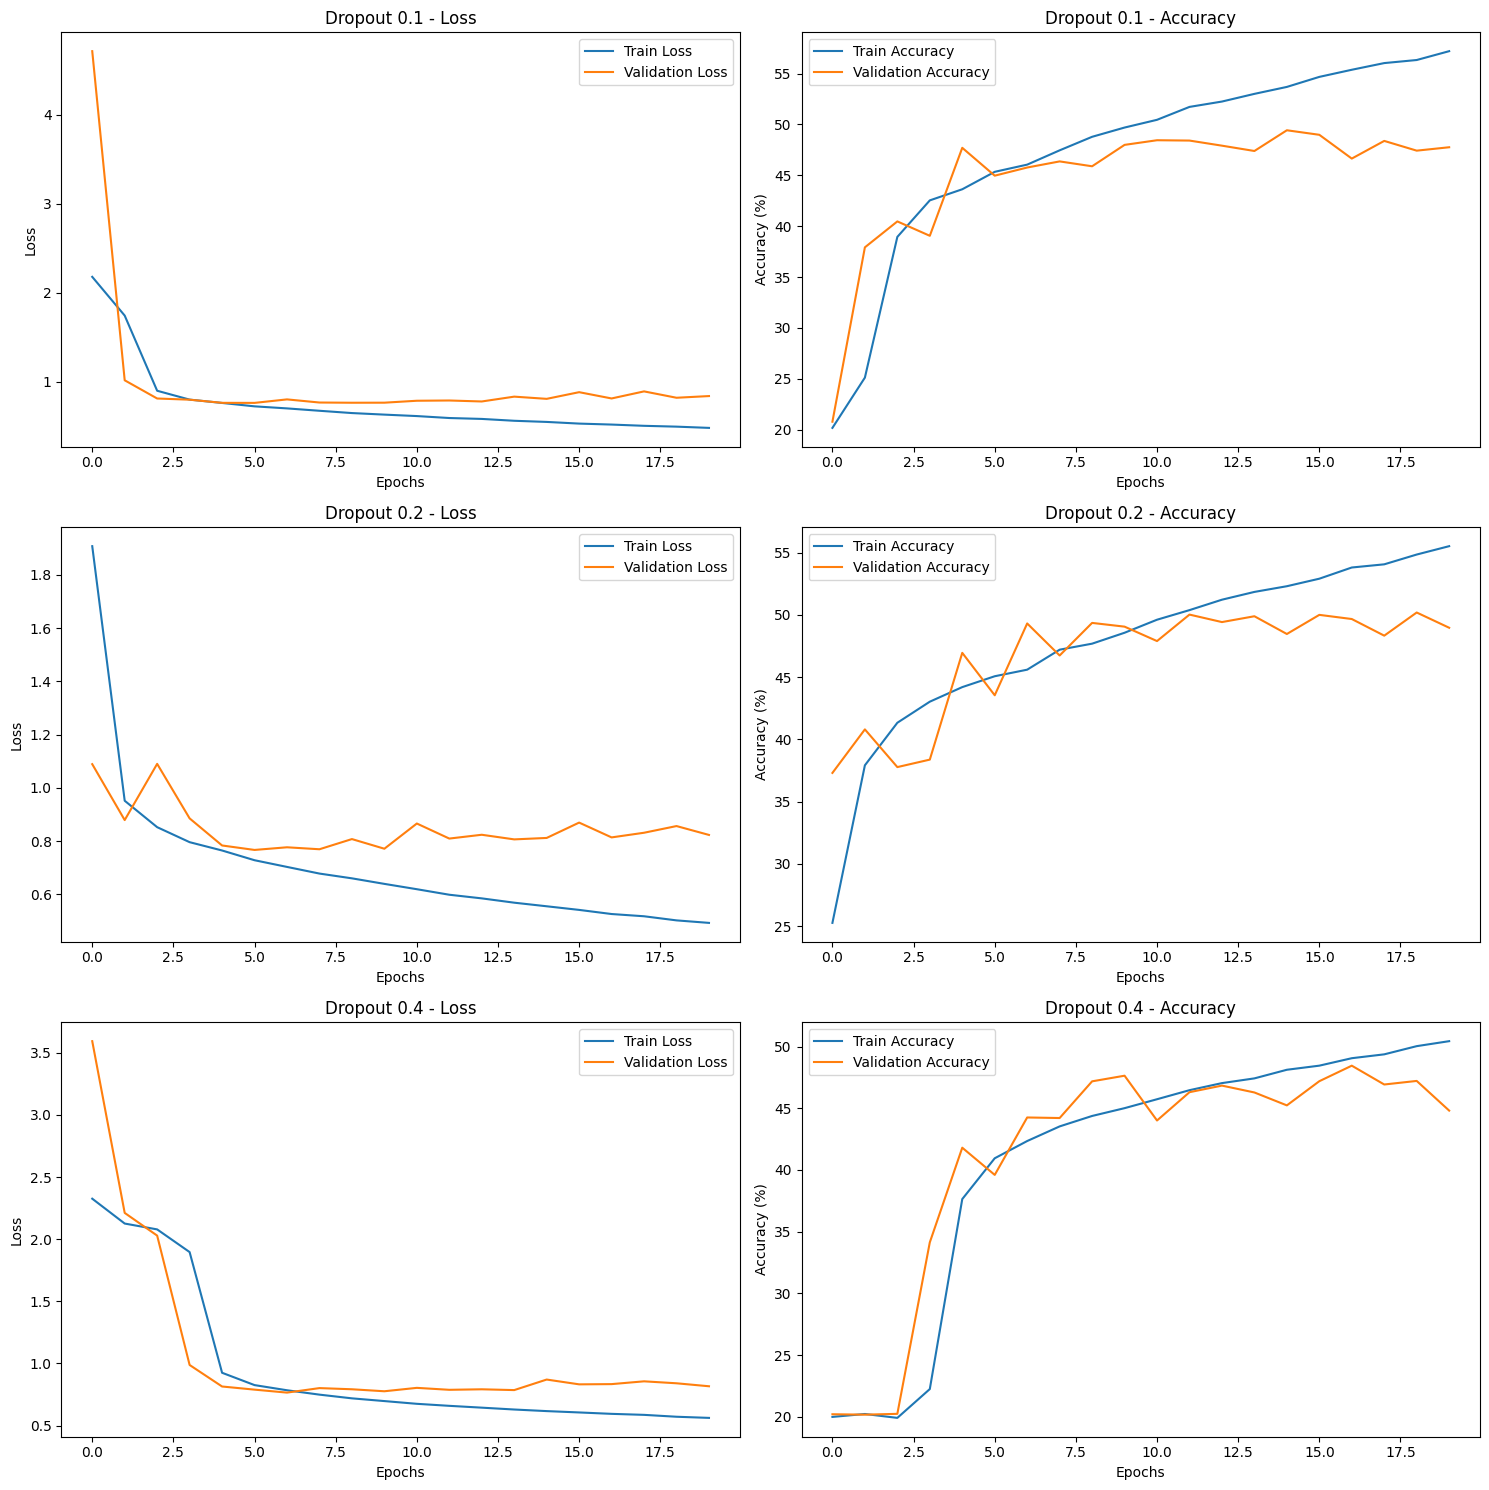

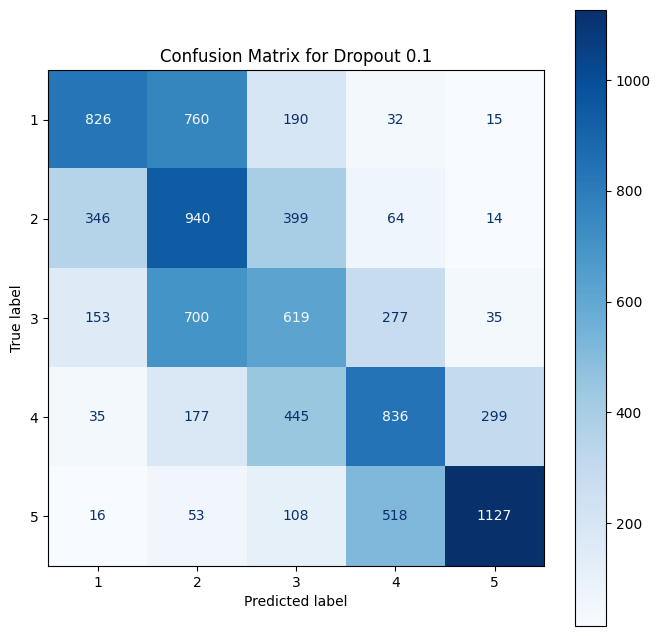

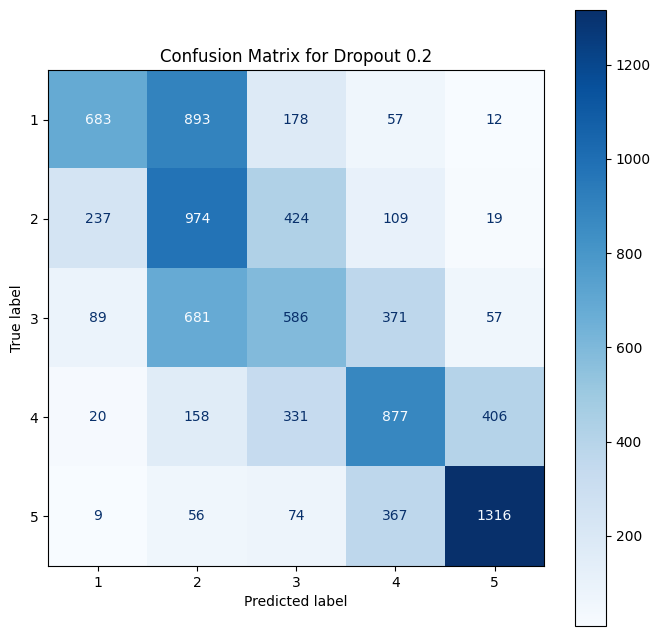

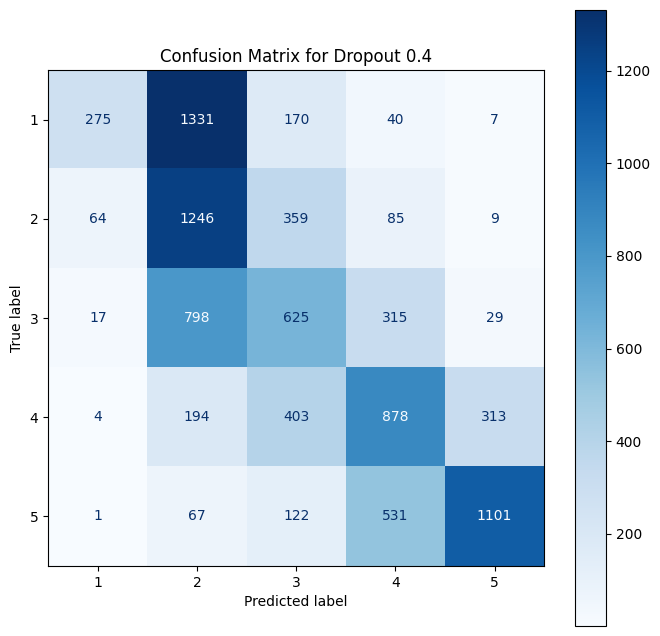

In [16]:
# Hyperparameters
embed_size = 100
hidden_size = 128
num_layers = 2
dropout_sizes = [0.1, 0.2, 0.4]
lr = 0.001
epochs = 20
weight_decay = 0.0001  

fig, axes = plt.subplots(len(dropout_sizes), 2, figsize=(15, 5 * len(dropout_sizes)))
confusion_matrices = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and evaluate for different dropout values
for i, dropout in enumerate(dropout_sizes):
    model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
            correct_train += (rounded_preds == targets).sum().item()
            total_train += targets.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
                correct_val += (rounded_preds == targets).sum().item()
                total_val += targets.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Dropout: {dropout}, Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    # Test Evaluation
    model.eval()
    test_targets, test_preds = [], []
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
            correct_test += (rounded_preds == targets).sum().item()
            total_test += targets.size(0)
            test_preds.extend(rounded_preds.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test
    print(f"Dropout: {dropout}, Test Accuracy: {test_accuracy:.2f}%")
    
    cm = confusion_matrix(test_targets, test_preds, labels=[1, 2, 3, 4, 5])
    confusion_matrices[dropout] = cm

    # Plot losses and accuracies
    ax1, ax2 = axes[i]
    ax1.plot(train_losses, label="Train Loss")
    ax1.plot(val_losses, label="Validation Loss")
    ax1.set_title(f"Dropout {dropout} - Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(train_accuracies, label="Train Accuracy")
    ax2.plot(val_accuracies, label="Validation Accuracy")
    ax2.set_title(f"Dropout {dropout} - Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrices
for dropout, cm in confusion_matrices.items():
    fig_cm, ax_cm = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
    disp.plot(cmap="Blues", values_format="d", ax=ax_cm)
    ax_cm.set_title(f"Confusion Matrix for Dropout {dropout}")
    plt.show()


## Hidden Size

Hidden Size: 32, Epoch 1/20, Train Loss: 2.4557, Train Accuracy: 20.27%, Val Loss: 2.5435, Val Accuracy: 20.23%
Hidden Size: 32, Epoch 2/20, Train Loss: 1.7786, Train Accuracy: 24.77%, Val Loss: 1.8236, Val Accuracy: 24.52%
Hidden Size: 32, Epoch 3/20, Train Loss: 1.7980, Train Accuracy: 23.62%, Val Loss: 1.8153, Val Accuracy: 24.26%
Hidden Size: 32, Epoch 4/20, Train Loss: 1.8711, Train Accuracy: 22.06%, Val Loss: 1.8900, Val Accuracy: 20.23%
Hidden Size: 32, Epoch 5/20, Train Loss: 1.8989, Train Accuracy: 21.38%, Val Loss: 1.8596, Val Accuracy: 20.24%
Hidden Size: 32, Epoch 6/20, Train Loss: 1.8207, Train Accuracy: 22.56%, Val Loss: 1.6907, Val Accuracy: 24.59%
Hidden Size: 32, Epoch 7/20, Train Loss: 1.7740, Train Accuracy: 23.07%, Val Loss: 1.8438, Val Accuracy: 22.64%
Hidden Size: 32, Epoch 8/20, Train Loss: 1.8270, Train Accuracy: 22.24%, Val Loss: 1.8753, Val Accuracy: 21.84%
Hidden Size: 32, Epoch 9/20, Train Loss: 1.9610, Train Accuracy: 20.53%, Val Loss: 1.9998, Val Accuracy:

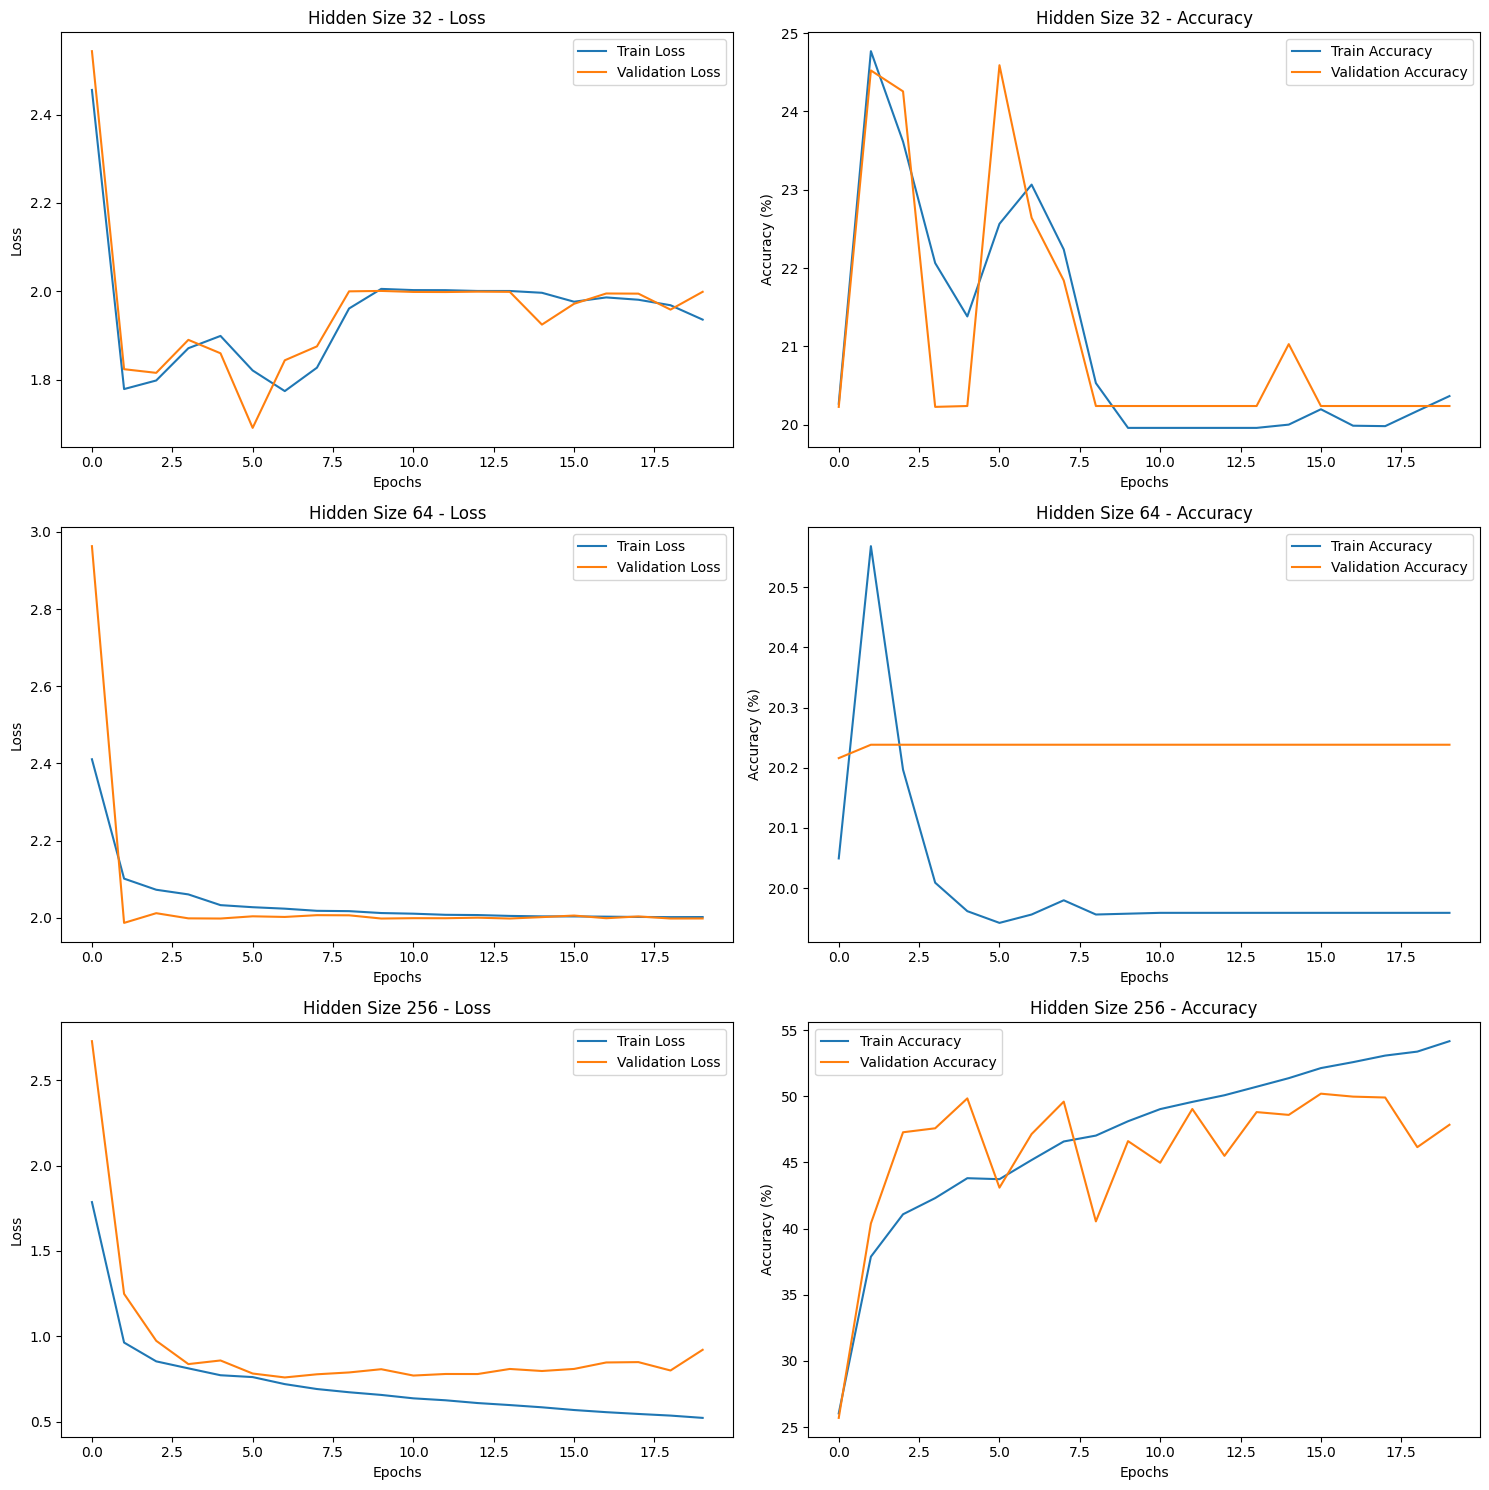

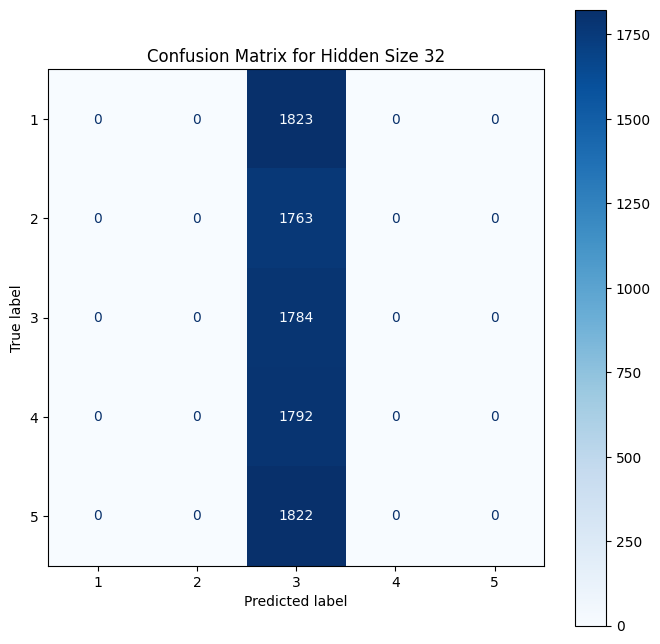

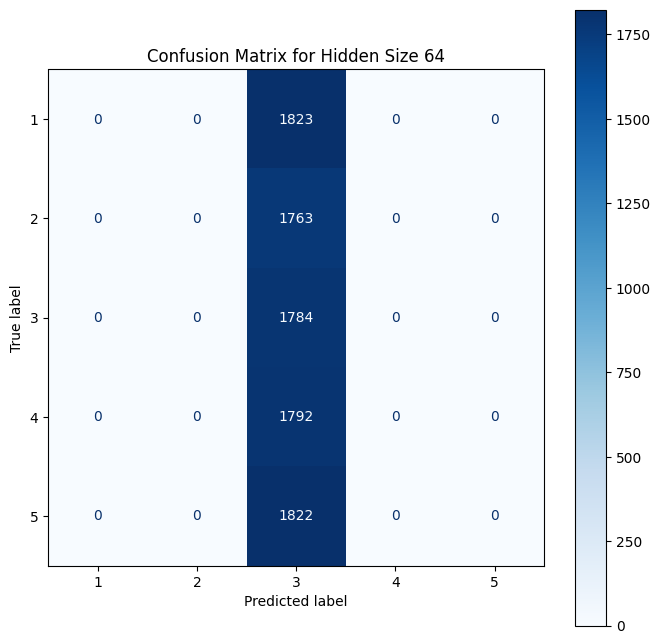

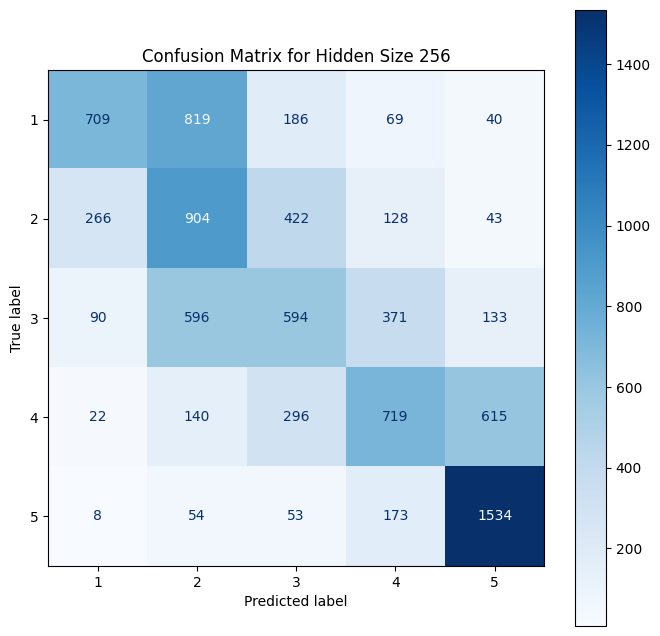

In [17]:
# Hyperparameters
embed_size = 100
num_layers = 2
dropout = 0.3 
hidden_sizes = [32, 64, 256] 
lr = 0.001  
epochs = 20
weight_decay = 1e-4 

fig, axes = plt.subplots(len(hidden_sizes), 2, figsize=(15, 5 * len(hidden_sizes)))
confusion_matrices = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and evaluate for different hidden size values
for i, hidden_size in enumerate(hidden_sizes):
    model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
            correct_train += (rounded_preds == targets).sum().item()
            total_train += targets.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
                correct_val += (rounded_preds == targets).sum().item()
                total_val += targets.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Hidden Size: {hidden_size}, Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    # Test Evaluation
    model.eval()
    test_targets, test_preds = [], []
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
            correct_test += (rounded_preds == targets).sum().item()
            total_test += targets.size(0)
            test_preds.extend(rounded_preds.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test
    print(f"Hidden Size: {hidden_size}, Test Accuracy: {test_accuracy:.2f}%")
    
    cm = confusion_matrix(test_targets, test_preds, labels=[1, 2, 3, 4, 5])
    confusion_matrices[hidden_size] = cm

    # Plot losses and accuracies
    ax1, ax2 = axes[i]
    ax1.plot(train_losses, label="Train Loss")
    ax1.plot(val_losses, label="Validation Loss")
    ax1.set_title(f"Hidden Size {hidden_size} - Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(train_accuracies, label="Train Accuracy")
    ax2.plot(val_accuracies, label="Validation Accuracy")
    ax2.set_title(f"Hidden Size {hidden_size} - Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrices
for hidden_size, cm in confusion_matrices.items():
    fig_cm, ax_cm = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
    disp.plot(cmap="Blues", values_format="d", ax=ax_cm)
    ax_cm.set_title(f"Confusion Matrix for Hidden Size {hidden_size}")
    plt.show()


## StepLR

Epoch 1/20, Train Loss: 1.9658, Train Accuracy: 23.58%, Val Loss: 1.8639, Val Accuracy: 29.67%
Epoch 2/20, Train Loss: 1.1325, Train Accuracy: 33.83%, Val Loss: 1.0361, Val Accuracy: 41.52%
Epoch 3/20, Train Loss: 0.9336, Train Accuracy: 37.53%, Val Loss: 0.9133, Val Accuracy: 44.31%
Epoch 4/20, Train Loss: 0.8439, Train Accuracy: 40.22%, Val Loss: 0.9073, Val Accuracy: 43.23%
Epoch 5/20, Train Loss: 0.7638, Train Accuracy: 42.91%, Val Loss: 0.8988, Val Accuracy: 39.05%
Epoch 6/20, Train Loss: 0.6546, Train Accuracy: 47.33%, Val Loss: 0.8098, Val Accuracy: 45.94%
Epoch 7/20, Train Loss: 0.5901, Train Accuracy: 49.95%, Val Loss: 0.8331, Val Accuracy: 48.11%
Epoch 8/20, Train Loss: 0.5360, Train Accuracy: 52.17%, Val Loss: 0.8600, Val Accuracy: 48.25%
Epoch 9/20, Train Loss: 0.4700, Train Accuracy: 55.81%, Val Loss: 0.9011, Val Accuracy: 48.64%
Epoch 10/20, Train Loss: 0.4150, Train Accuracy: 58.78%, Val Loss: 0.8850, Val Accuracy: 47.37%
Epoch 11/20, Train Loss: 0.3300, Train Accuracy: 

<Figure size 800x800 with 0 Axes>

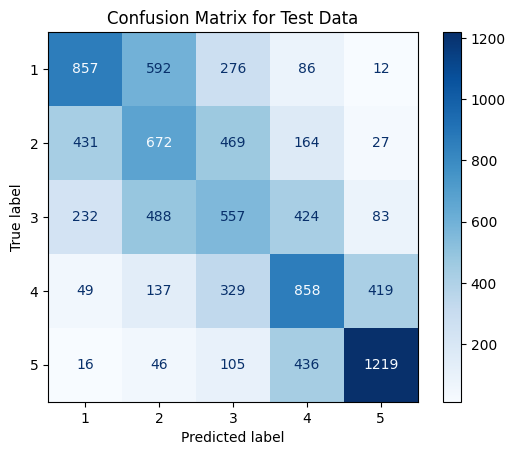

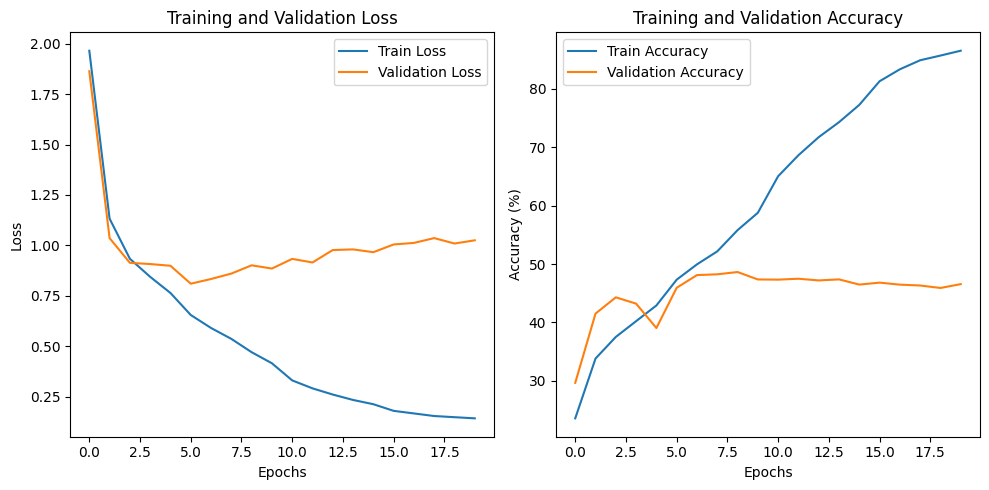

In [18]:
from torch.optim.lr_scheduler import StepLR

model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, dropout)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# StepLR Scheduler
step_size = 5  
gamma = 0.5  
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training and validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Round outputs to nearest integer and clamp between 1 and 5
        rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
        correct_train += (rounded_preds == targets).sum().item()
        total_train += targets.size(0)

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Round outputs to nearest integer and clamp between 1 and 5
            rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
            correct_val += (rounded_preds == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    scheduler.step()

# Evaluate on test data
model.eval()
test_targets, test_preds = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).squeeze()
        rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
        test_preds.extend(rounded_preds.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# Test Accuracy
correct_test = sum(1 for t, p in zip(test_targets, test_preds) if t == p)
total_test = len(test_targets)
test_accuracy = 100 * correct_test / total_test 

# Test MAE (Mean Absolute Error)
mae = mean_absolute_error(test_targets, test_preds)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test MAE: {mae:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_targets, test_preds, labels=[1, 2, 3, 4, 5])

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Test Data')
plt.show()

# Plot losses and accuracies
plt.figure(figsize=(10, 5))

# Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Using layer norm instead of batch norm, bidirectional LSTM synonym replacement, and some hyperparameter tuning (Optimized Model)

100%|██████████| 89832/89832 [00:18<00:00, 4835.44it/s] 


Epoch 1/30, Train Loss: 2.0800, Val Loss: 1.9901, Train Acc: 0.2000, Val Acc: 0.2041
Epoch 2/30, Train Loss: 2.0662, Val Loss: 2.0096, Train Acc: 0.1999, Val Acc: 0.2041
Epoch 3/30, Train Loss: 2.0559, Val Loss: 1.9826, Train Acc: 0.2001, Val Acc: 0.2053
Epoch 4/30, Train Loss: 2.0443, Val Loss: 1.9815, Train Acc: 0.2016, Val Acc: 0.2049
Epoch 5/30, Train Loss: 2.0150, Val Loss: 1.9792, Train Acc: 0.2030, Val Acc: 0.2056
Epoch 6/30, Train Loss: 1.8156, Val Loss: 1.0717, Train Acc: 0.2292, Val Acc: 0.3227
Epoch 7/30, Train Loss: 0.9435, Val Loss: 0.8434, Train Acc: 0.3537, Val Acc: 0.3485
Epoch 8/30, Train Loss: 0.8160, Val Loss: 0.7931, Train Acc: 0.3873, Val Acc: 0.4216
Epoch 9/30, Train Loss: 0.7232, Val Loss: 0.7466, Train Acc: 0.4413, Val Acc: 0.4882
Epoch 10/30, Train Loss: 0.6570, Val Loss: 0.6920, Train Acc: 0.4883, Val Acc: 0.5082
Epoch 11/30, Train Loss: 0.5948, Val Loss: 0.6757, Train Acc: 0.5281, Val Acc: 0.5170
Epoch 12/30, Train Loss: 0.5840, Val Loss: 0.6732, Train Acc: 0

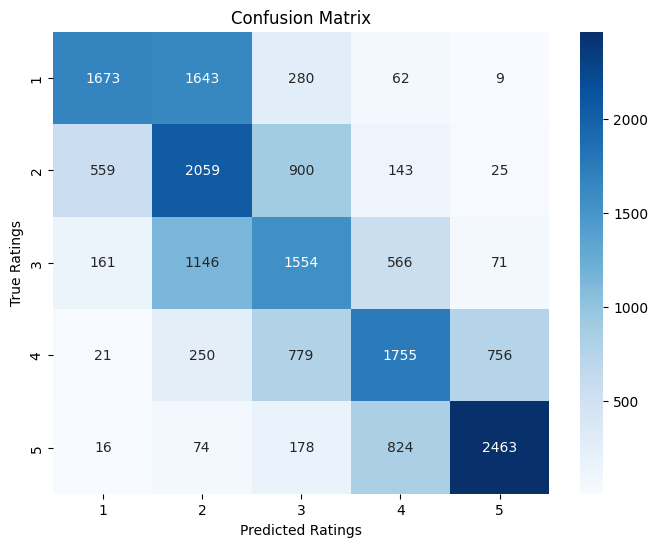

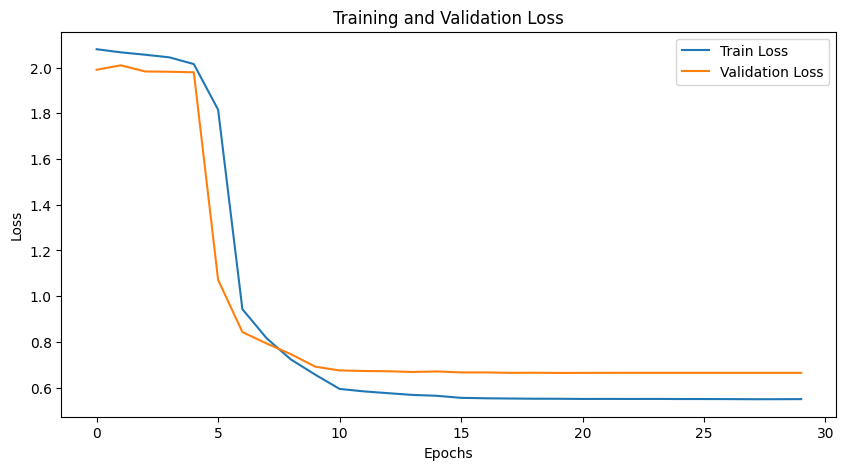

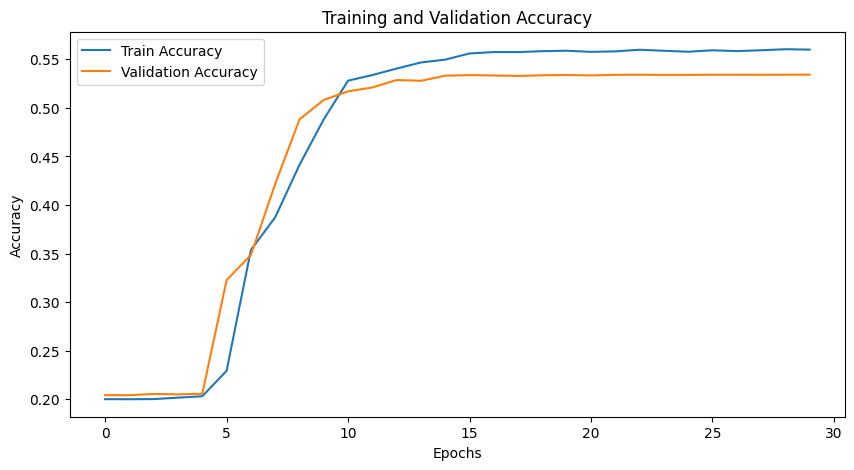

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from tqdm import tqdm
import random

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

df = df.dropna(subset=['review_description']) 
reviews = df['review_description']
ratings = df['rating']

tqdm.pandas()
reviews = reviews.progress_apply(lambda text: word_tokenize(text))  
reviews = reviews[reviews.apply(len) > 0] 
ratings = ratings.loc[reviews.index]  

# Data Augmentation: Synonym Replacement
def synonym_replacement(review, n=1):
    if len(review) == 0:  
        return review
    augmented_review = review.copy()
    for _ in range(n):
        word_idx = random.randint(0, len(augmented_review) - 1)
        word = augmented_review[word_idx]
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            augmented_review[word_idx] = synonym
    return augmented_review

augmented_reviews = reviews.progress_apply(lambda review: synonym_replacement(review, n=2))
reviews = pd.concat([reviews, augmented_reviews])  
ratings = pd.concat([ratings, ratings])  

# Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for review in reviews for word in review))}
vocab_size = len(vocab) + 1  # +1 for padding

# Convert reviews to sequences
max_seq_len = 100
reviews_seq = [
    [vocab.get(word, 0) for word in review[:max_seq_len]] + [0] * (max_seq_len - len(review))
    for review in reviews
]

# Convert to tensors
X = torch.tensor(reviews_seq, dtype=torch.long)
y = torch.tensor(ratings.values, dtype=torch.float32)  

# Train-test split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    list(zip(X, y)), [train_size, val_size, test_size]
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class RNNRegressionModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout):
        super(RNNRegressionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2) 
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size * 2, 1) 
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.layer_norm(x[:, -1, :]) 
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc(x).squeeze(-1)

# Hyperparameters
embed_size = 200
hidden_size = 256
num_layers = 2
dropout = 0.5
lr = 0.001
lr_decay_factor = 0.1
lr_decay_step = 5
weight_decay = 1e-5
epochs = 30

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNRegressionModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_factor)

# Training and validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        predicted = torch.clamp(torch.round(outputs), 1, 5)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(correct_train / total_train)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            predicted = torch.clamp(torch.round(outputs), 1, 5)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(correct_val / total_val)

    scheduler.step()

    print(
        f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
        f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}"
    )

# Test the model
model.eval()
test_targets, test_preds = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_preds.extend(outputs.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# Convert predictions to discrete ratings
test_preds_rounded = np.clip(np.round(test_preds), 1, 5)

# Calculate test accuracy
correct_test = np.sum(test_preds_rounded == test_targets)
total_test = len(test_targets)
test_accuracy = correct_test / total_test * 100 
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate final MSE
final_mse = mean_squared_error(test_targets, test_preds_rounded)
print(f"Test MSE: {final_mse:.4f}")

# Precision, Recall, and F1 Score
precision = precision_score(test_targets, test_preds_rounded, average='weighted', zero_division=0)
recall = recall_score(test_targets, test_preds_rounded, average='weighted', zero_division=0)
f1 = f1_score(test_targets, test_preds_rounded, average='weighted', zero_division=0)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_targets, test_preds_rounded)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5]
)
plt.xlabel("Predicted Ratings")
plt.ylabel("True Ratings")
plt.title("Confusion Matrix")
plt.show()

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


### Calculating Model FLOPs per forward pass and other statistics

In [32]:
from ptflops import get_model_complexity_info

# Function to print model summary
def print_model_summary(model):
    total_params = 0
    lstm_params = 0
    fc_params = 0
    embedding_params = 0

    print(f"{'Layer':<30}{'Parameters':<15}")
    print("=" * 45)
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            if 'embedding' in name:
                embedding_params += num_params
            elif 'lstm' in name:
                lstm_params += num_params
            elif 'fc' in name:
                fc_params += num_params
    
    # Print combined layers
    print(f"{'Embedding':<30}{embedding_params:<15}")
    print(f"{'LSTM (combined)':<30}{lstm_params:<15}")
    print(f"{'FC (combined)':<30}{fc_params:<15}")
    print("=" * 45)
    print(f"{'Total Parameters':<30}{total_params:<15}")


model = RNNRegressionModel(vocab_size, embed_size, hidden_size, num_layers, dropout).to(device)
print_model_summary(model)


# Calculate model complexity
macs, params = get_model_complexity_info(
    model, 
    (max_seq_len,), 
    input_constructor=lambda x: torch.randint(0, vocab_size, (batch_size, max_seq_len)).to(device),
    verbose=False
)

# Extract numeric value from MACs string and convert to float
macs_value = float(macs.split()[0])
flops_value = macs_value * 2

print(f"Total MACs: {macs_value} M")
print(f"Total FLOPs: {flops_value} M")

# Model size in MB
model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 ** 2)
print(f"Model Size: {model_size_mb:.2f} MB")


Layer                         Parameters     
Embedding                     6519200        
LSTM (combined)               2514944        
FC (combined)                 513            
Total Parameters              9035681        
RNNRegressionModel(
  2.52 M, 27.850% Params, 252.52 MMac, 99.994% MACs, 
  (embedding): Embedding(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 32596, 200, padding_idx=0)
  (lstm): LSTM(2.51 M, 27.833% Params, 252.52 MMac, 99.993% MACs, 200, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (layer_norm): LayerNorm(1.02 k, 0.011% Params, 512.0 Mac, 0.000% MACs, (512,), eps=1e-05, elementwise_affine=True)
  (relu): ReLU(0, 0.000% Params, 512.0 Mac, 0.000% MACs, )
  (fc): Linear(513, 0.006% Params, 513.0 Mac, 0.000% MACs, in_features=512, out_features=1, bias=True)
  (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.5, inplace=False)
)
Total MACs: 252.54 M
Total FLOPs: 505.08 M
Model Size: 34.47 MB


# Electra Model

## Base Model

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\dhair\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20 - Train Loss: 1.1737, Train Acc: 0.4794, Val Loss: 1.0708, Val Acc: 0.5343
Epoch 2/20 - Train Loss: 1.0556, Train Acc: 0.5392, Val Loss: 1.0520, Val Acc: 0.5391
Epoch 3/20 - Train Loss: 1.0020, Train Acc: 0.5644, Val Loss: 1.0646, Val Acc: 0.5408
Epoch 4/20 - Train Loss: 0.9533, Train Acc: 0.5892, Val Loss: 1.0666, Val Acc: 0.5458
Epoch 5/20 - Train Loss: 0.9012, Train Acc: 0.6127, Val Loss: 1.1035, Val Acc: 0.5424
Epoch 6/20 - Train Loss: 0.8518, Train Acc: 0.6370, Val Loss: 1.1006, Val Acc: 0.5360
Epoch 7/20 - Train Loss: 0.8011, Train Acc: 0.6620, Val Loss: 1.1731, Val Acc: 0.5308
Epoch 8/20 - Train Loss: 0.7528, Train Acc: 0.6855, Val Loss: 1.2118, Val Acc: 0.5349
Epoch 9/20 - Train Loss: 0.7009, Train Acc: 0.7108, Val Loss: 1.3038, Val Acc: 0.5253
Epoch 10/20 - Train Loss: 0.6552, Train Acc: 0.7338, Val Loss: 1.2862, Val Acc: 0.5181
Epoch 11/20 - Train Loss: 0.6123, Train Acc: 0.7521, Val Loss: 1.3734, Val Acc: 0.5144
Epoch 12/20 - Train Loss: 0.5678, Train Acc: 0.7725,

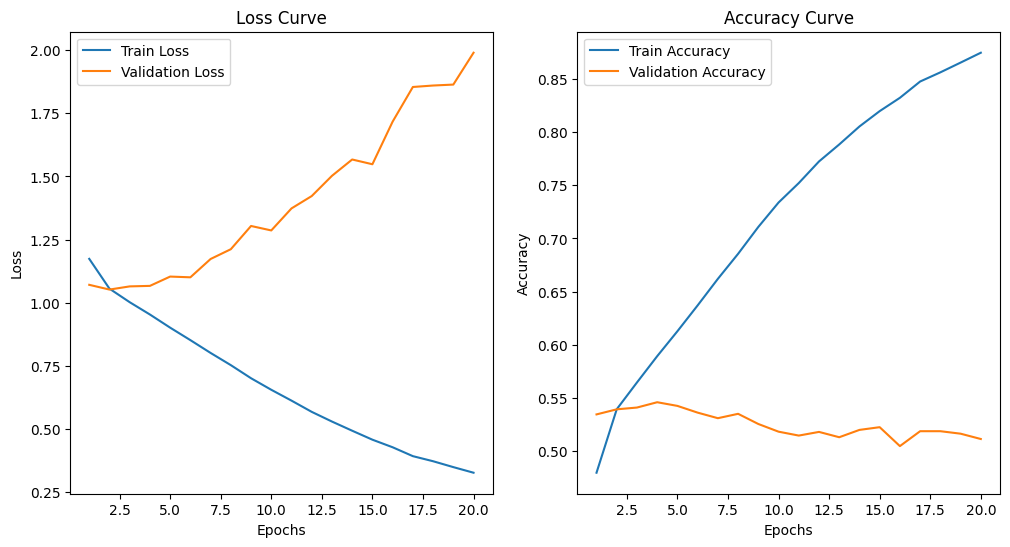

Test Accuracy: 0.5083


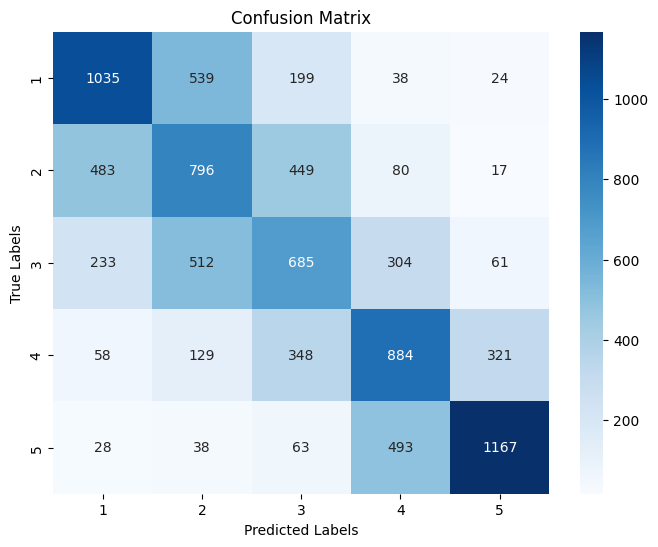

In [6]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = df.dropna(subset=['review_description'])
ratings = df['rating'].values
reviews = df['review_description'].values

# Tokenizer and model setup
tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")
model = ElectraForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels=5)

# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, tokenizer, max_len=128):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.ratings[idx] - 1  
        encoding = self.tokenizer(
            review,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

dataset = ReviewDataset(reviews, ratings, tokenizer)

# Train/Val/Test Split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds_list, labels_list = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total, preds_list, labels_list

# Training loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(20):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/20 - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Plotting metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), train_losses, label="Train Loss")
plt.plot(range(1, 21), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), train_accuracies, label="Train Accuracy")
plt.plot(range(1, 21), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

# Test evaluation
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

class_names = [1, 2, 3, 4, 5]

plot_confusion_matrix(cm, class_names)


## Hyperparameter tuning on Electra model (hidden layers frozen) using Optuna

[I 2024-12-12 20:58:32,489] A new study created in memory with name: no-name-29b25c6a-d947-4f3c-9adc-2ad0463bdfb4
C:\Users\dhair\AppData\Local\Temp\ipykernel_2012\4017691135.py:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\dhair\AppData\Local\Temp\ipykernel_2012\4017691135.py:98: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.d

Best hyperparameters: {'learning_rate': 4.484879154813824e-05, 'weight_decay': 1.25064315773544e-06, 'max_len': 100, 'batch_size': 16}


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 - Train Loss: 1.5287, Train Acc: 0.3041, Val Loss: 1.4514, Val Acc: 0.3519
Epoch 2/20 - Train Loss: 1.4879, Train Acc: 0.3270, Val Loss: 1.4311, Val Acc: 0.3657
Epoch 3/20 - Train Loss: 1.4790, Train Acc: 0.3347, Val Loss: 1.4170, Val Acc: 0.3765
Epoch 4/20 - Train Loss: 1.4768, Train Acc: 0.3337, Val Loss: 1.4144, Val Acc: 0.3784
Epoch 5/20 - Train Loss: 1.4735, Train Acc: 0.3384, Val Loss: 1.4107, Val Acc: 0.3768
Epoch 6/20 - Train Loss: 1.4714, Train Acc: 0.3371, Val Loss: 1.4057, Val Acc: 0.3817
Epoch 7/20 - Train Loss: 1.4736, Train Acc: 0.3344, Val Loss: 1.4070, Val Acc: 0.3837
Epoch 8/20 - Train Loss: 1.4710, Train Acc: 0.3396, Val Loss: 1.4024, Val Acc: 0.3815
Epoch 9/20 - Train Loss: 1.4676, Train Acc: 0.3426, Val Loss: 1.3998, Val Acc: 0.3892
Epoch 10/20 - Train Loss: 1.4682, Train Acc: 0.3394, Val Loss: 1.3994, Val Acc: 0.3824
Epoch 11/20 - Train Loss: 1.4675, Train Acc: 0.3395, Val Loss: 1.4007, Val Acc: 0.3868
Epoch 12/20 - Train Loss: 1.4667, Train Acc: 0.3413,

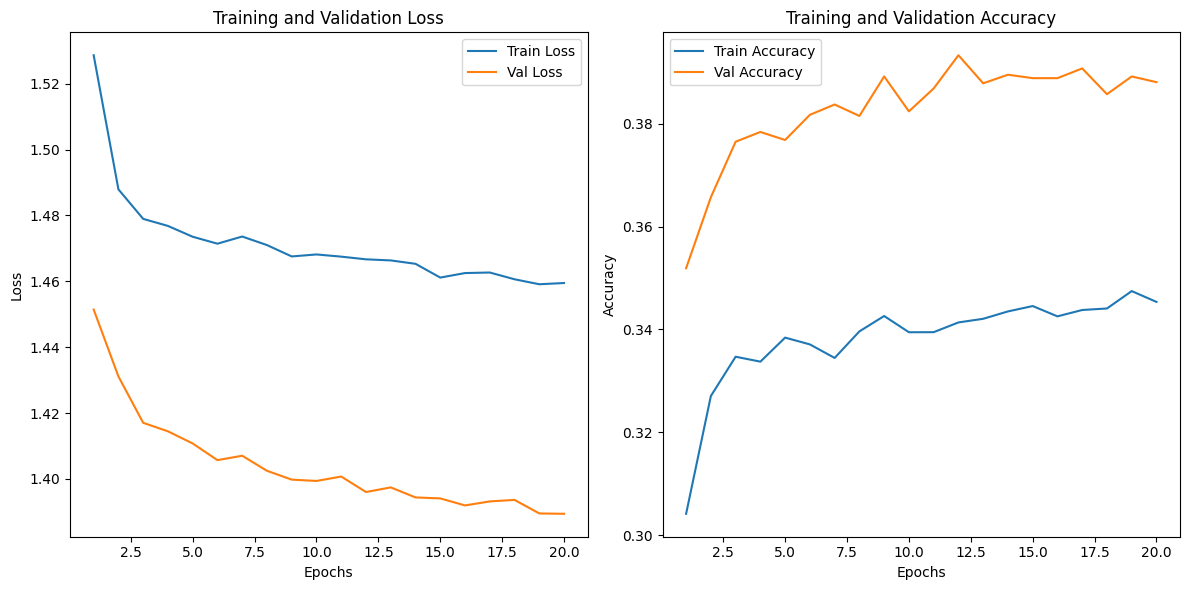

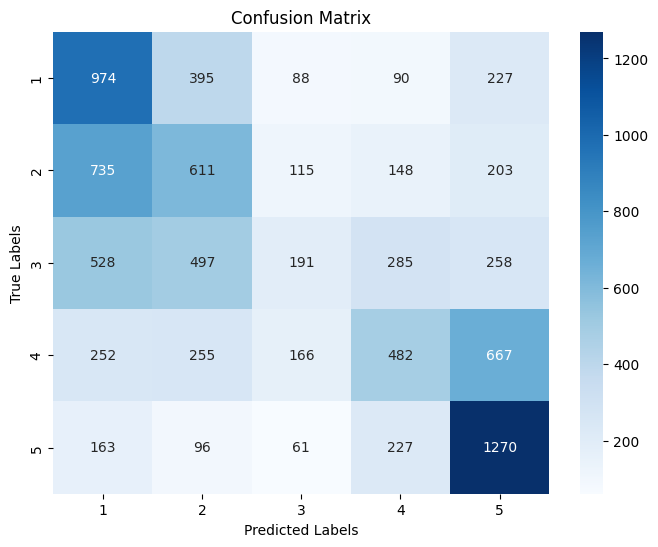

In [5]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import optuna
import seaborn as sns

df = df.dropna(subset=['review_description'])
ratings = df['rating'].values
reviews = df['review_description'].values

tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")

# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, tokenizer, max_len=128):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.ratings[idx] - 1 
        encoding = self.tokenizer(
            review,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare dataset and splits
dataset = ReviewDataset(reviews, ratings, tokenizer)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to freeze model layers
def freeze_hidden_layers(model):
    for name, param in model.named_parameters():
        if "classifier" not in name:  
            param.requires_grad = False

# Define train and evaluation functions
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

# Optuna optimization objective function
def objective(trial):
    # Hyperparameter search space
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    max_len = trial.suggest_int('max_len', 64, 256)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    dataset = ReviewDataset(reviews, ratings, tokenizer, max_len=max_len)

    # Use only 50% of training data and 25% of validation data
    partial_train_size = int(0.5 * train_size)
    partial_val_size = int(0.25 * val_size)
    _, partial_train_dataset = random_split(dataset, [len(dataset) - partial_train_size, partial_train_size])
    _, partial_val_dataset = random_split(dataset, [len(dataset) - partial_val_size, partial_val_size])

    train_loader = DataLoader(partial_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(partial_val_dataset, batch_size=batch_size)

    model = ElectraForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels=5)
    freeze_hidden_layers(model)
    model.to(device)
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop for a few epochs
    best_val_acc = 0
    for epoch in range(5): 
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

# Run Optuna search
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)

# Train final model with best hyperparameters
best_params = study.best_params
dataset = ReviewDataset(reviews, ratings, tokenizer, max_len=best_params['max_len'])
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

model = ElectraForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels=5)
freeze_hidden_layers(model)
model.to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
criterion = torch.nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(20):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/20 - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Test evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), train_losses, label="Train Loss")
plt.plot(range(1, 21), val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), train_accuracies, label="Train Accuracy")
plt.plot(range(1, 21), val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.tight_layout()
plt.show()

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Compute and plot confusion matrix
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
class_names = [1, 2, 3, 4, 5]
plot_confusion_matrix(cm, class_names)


# Increasing model complexity

## Classification

100%|██████████| 89835/89835 [00:14<00:00, 6067.23it/s]


Epoch 1/20, Train Loss: 1.6111, Train Accuracy: 19.78%, Val Loss: 1.6070, Val Accuracy: 20.08%
Epoch 2/20, Train Loss: 1.6037, Train Accuracy: 20.85%, Val Loss: 1.5581, Val Accuracy: 26.86%
Epoch 3/20, Train Loss: 1.5767, Train Accuracy: 24.26%, Val Loss: 1.5627, Val Accuracy: 25.44%
Epoch 4/20, Train Loss: 1.5783, Train Accuracy: 23.64%, Val Loss: 1.5840, Val Accuracy: 23.02%
Epoch 5/20, Train Loss: 1.5579, Train Accuracy: 24.91%, Val Loss: 1.4688, Val Accuracy: 31.53%
Epoch 6/20, Train Loss: 1.4266, Train Accuracy: 33.90%, Val Loss: 1.3676, Val Accuracy: 36.54%
Epoch 7/20, Train Loss: 1.3298, Train Accuracy: 37.65%, Val Loss: 1.2943, Val Accuracy: 39.70%
Epoch 8/20, Train Loss: 1.2660, Train Accuracy: 41.11%, Val Loss: 1.2796, Val Accuracy: 40.79%
Epoch 9/20, Train Loss: 1.2294, Train Accuracy: 43.80%, Val Loss: 1.2177, Val Accuracy: 44.47%
Epoch 10/20, Train Loss: 1.1907, Train Accuracy: 46.42%, Val Loss: 1.1840, Val Accuracy: 46.67%
Epoch 11/20, Train Loss: 1.1575, Train Accuracy: 

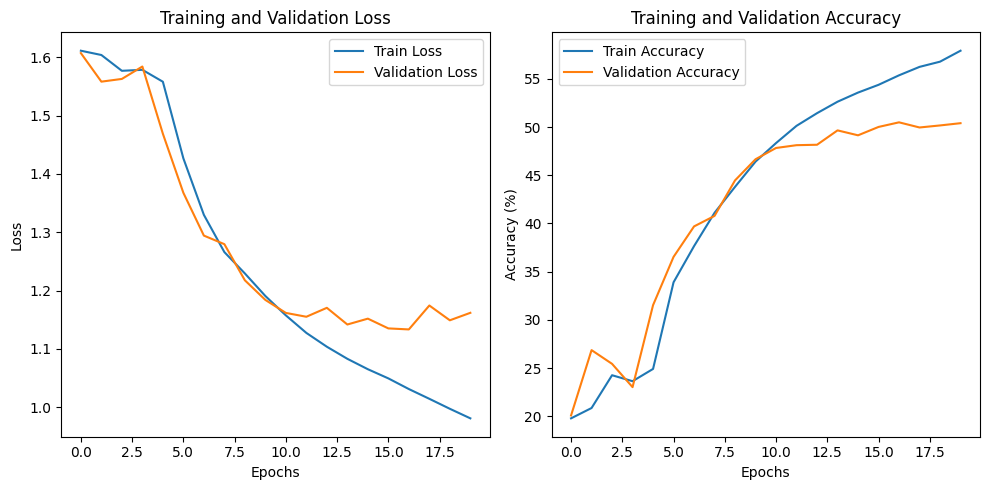

<Figure size 800x800 with 0 Axes>

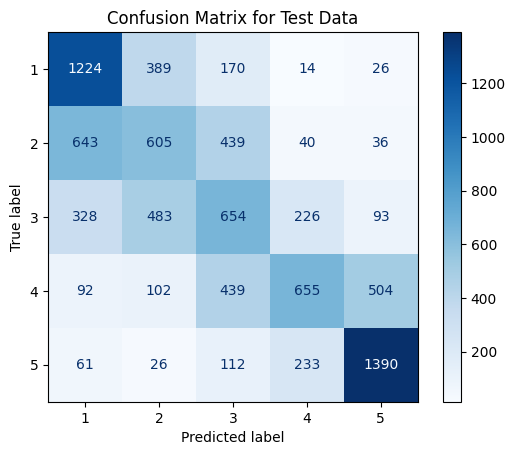

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

df = df.dropna(subset=['review_description'])  
reviews = df['review_description']
ratings = df['rating']

# Tokenize reviews
tqdm.pandas()
reviews = reviews.progress_apply(lambda text: word_tokenize(text))

# Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for review in reviews for word in review))}
vocab_size = len(vocab) + 1

# Convert reviews to padded sequences
max_seq_len = 100
reviews_seq = [[vocab.get(word, 0) for word in review[:max_seq_len]] + [0] * (max_seq_len - len(review)) for review in reviews]

# Convert to tensors
X = torch.tensor(reviews_seq, dtype=torch.long)
y = torch.tensor(ratings.values - 1, dtype=torch.long)  

# Train-test split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(list(zip(X, y)), [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class EnhancedRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, output_size, dropout):
        super(EnhancedRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, 
                            bidirectional=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(2 * hidden_size)
        self.fc1 = nn.Linear(2 * hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  
        x = self.layer_norm(x)
        x = self.relu(self.fc1(x))  
        x = self.dropout(x)
        return self.fc2(x) 

# Hyperparameters
embed_size = 100
hidden_size = 128
num_layers = 2
output_size = 5 
dropout = 0.3
lr = 0.0001
epochs = 20

# Initialize model
model = EnhancedRNNModel(vocab_size, embed_size, hidden_size, num_layers, output_size, dropout)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training and validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Evaluate on test data
model.eval()
test_targets, test_preds = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# Test Accuracy
test_accuracy = accuracy_score(test_targets, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation loss and accuracy
plt.figure(figsize=(10, 5))

# Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_targets, test_preds, labels=list(range(output_size)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1, output_size + 1)))

# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Test Data')
plt.show()


## Regression

100%|██████████| 89835/89835 [00:07<00:00, 12221.98it/s]


Epoch 1/20, Train Loss: 2.1253, Train Accuracy: 20.05%, Val Loss: 1.9928, Val Accuracy: 20.34%
Epoch 2/20, Train Loss: 2.0683, Train Accuracy: 19.98%, Val Loss: 1.9918, Val Accuracy: 20.37%
Epoch 3/20, Train Loss: 2.0647, Train Accuracy: 20.09%, Val Loss: 1.9986, Val Accuracy: 20.37%
Epoch 4/20, Train Loss: 2.0564, Train Accuracy: 20.26%, Val Loss: 1.9969, Val Accuracy: 20.36%
Epoch 5/20, Train Loss: 1.8266, Train Accuracy: 23.58%, Val Loss: 1.1384, Val Accuracy: 31.11%
Epoch 6/20, Train Loss: 1.0957, Train Accuracy: 34.42%, Val Loss: 1.0247, Val Accuracy: 37.56%
Epoch 7/20, Train Loss: 0.9810, Train Accuracy: 36.45%, Val Loss: 0.9218, Val Accuracy: 35.90%
Epoch 8/20, Train Loss: 0.9139, Train Accuracy: 37.84%, Val Loss: 0.8876, Val Accuracy: 39.19%
Epoch 9/20, Train Loss: 0.8742, Train Accuracy: 38.72%, Val Loss: 0.8683, Val Accuracy: 40.64%
Epoch 10/20, Train Loss: 0.8389, Train Accuracy: 40.10%, Val Loss: 0.8570, Val Accuracy: 43.84%
Epoch 11/20, Train Loss: 0.8112, Train Accuracy: 

<Figure size 800x800 with 0 Axes>

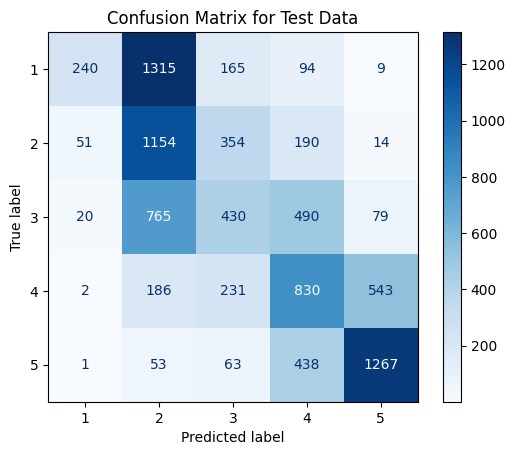

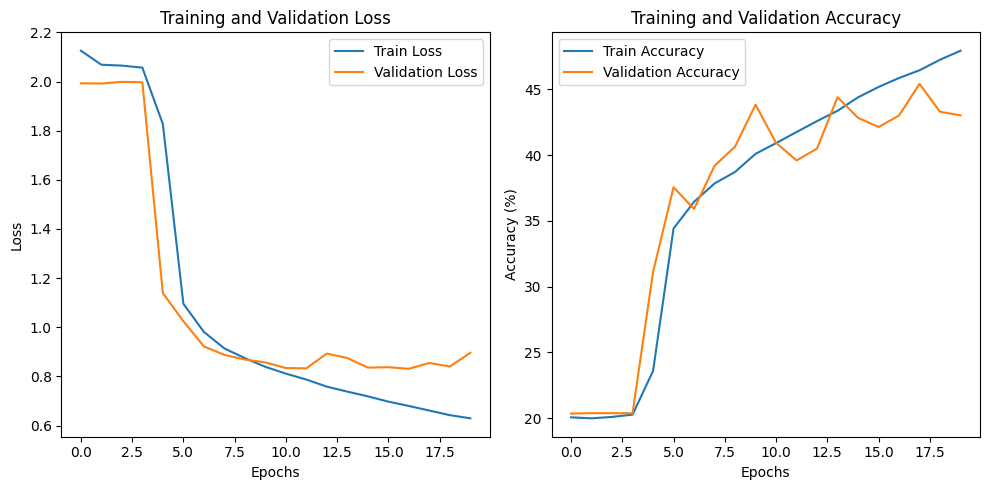

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm


torch.manual_seed(42)
np.random.seed(42)

reviews = df['review_description']
ratings = df['rating']

df = df.dropna(subset=['review_description'])
reviews = df['review_description']

# Tokenize reviews with a progress bar
tqdm.pandas()  
reviews = reviews.progress_apply(lambda text: word_tokenize(text))

# Build vocabulary
vocab = {word: idx + 1 for idx, word in enumerate(set(word for review in reviews for word in review))} 
vocab_size = len(vocab) + 1 

# Convert reviews to sequences
max_seq_len = 100  
reviews_seq = [[vocab.get(word, 0) for word in review[:max_seq_len]] + [0] * (max_seq_len - len(review)) for review in reviews]

# Convert to tensors
X = torch.tensor(reviews_seq, dtype=torch.long)
y = torch.tensor(ratings.values, dtype=torch.float32)  

# Train-test split
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(list(zip(X, y)), [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, output_size=1):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, 
                            bidirectional=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(2 * hidden_size)
        self.fc1 = nn.Linear(2 * hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :] 
        x = self.layer_norm(x) 
        x = self.fc1(x) 
        x = self.relu(x)  
        x = self.dropout(x) 
        return self.fc2(x) 

# Hyperparameters
embed_size = 100
hidden_size = 128
num_layers = 2
dropout = 0.3
lr = 0.0001
epochs = 20

model = RNNModel(vocab_size, embed_size, hidden_size, num_layers, dropout)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training and validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Round outputs to nearest integer and clamp between 1 and 5
        rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
        correct_train += (rounded_preds == targets).sum().item()
        total_train += targets.size(0)

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Round outputs to nearest integer and clamp between 1 and 5
            rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
            correct_val += (rounded_preds == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Evaluate on test data
model.eval()
test_targets, test_preds = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).squeeze()
        rounded_preds = torch.clamp(torch.round(outputs), min=1, max=5)
        test_preds.extend(rounded_preds.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# Test Accuracy
correct_test = sum(1 for t, p in zip(test_targets, test_preds) if t == p)
total_test = len(test_targets)
test_accuracy = 100 * correct_test / total_test  

# Test MAE (Mean Absolute Error)
mae = mean_absolute_error(test_targets, test_preds)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test MAE: {mae:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_targets, test_preds, labels=[1, 2, 3, 4, 5])

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])

# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Test Data')
plt.show()

# Plot losses and accuracies
plt.figure(figsize=(10, 5))

# Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
